This Jupyter notebook uses the Sprague multipliers' methodology outlined in the paper "Reconstructing school-age populations by estimating population by single years of age for different polygons from raster data" for the Canadian Census of 2016. It uses raster data from WorldPop (https://www.worldpop.org/geodata/summary?id=15778), and the information on the Census was obtained from Statistics Canada (https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/dt-td/Rp-eng.cfm?TABID=4&LANG=E&A=R&APATH=3&DETAIL=0&DIM=0&FL=A&FREE=0&GC=10&GL=-1&GID=1235626&GK=1&GRP=1&O=D&PID=109523&PRID=10&PTYPE=109445&S=0&SHOWALL=0&SUB=0&Temporal=2016&THEME=115&VID=0&VNAMEE=&VNAMEF=&D1=0&D2=0&D3=0&D4=0&D5=0&D6=0), from the 2016 National Census, particularly for Census Metropolitan Areas and Census Agglomerations. 

The information on the starting age and duration of each educational level, used for the reconstruction of the educational level populations for both census and projection data was obtained from data.uis.unesco.org, and is shown below:

In [1]:
import pandas as pd
EducationSystem = {"Educational level": ["ECE", "Pre-primary", "Primary", "Lower secondary", "Upper secondary"], "Starting age": ["3","5","6","12","15"], "Duration":["3","1","6","3","3"]}
EducationSystem = pd.DataFrame(EducationSystem)  
print(EducationSystem)

  Educational level Starting age Duration
0               ECE            3        3
1       Pre-primary            5        1
2           Primary            6        6
3   Lower secondary           12        3
4   Upper secondary           15        3


We start by importing all the necessary modules

In [1]:
import sys, os, csv, math, statsmodels
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.stats.diagnostic as diag
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import jarque_bera
%matplotlib inline
%config InlineBackend.figure_format='retina'
pd.options.mode.chained_assignment = None

The user is prompted to insert the appropriate working directory

In [2]:
os.chdir("C:\\Users\\g.vargas\\BOX\\IIEP_MyProjects\\MP_01000298\\WorkFiles_Experts\\298-Issue-Papers\\298-Issue-Paper-Sprague\\Replication files\\Data\\Tables\\Canada")  # REMOVE
if os.getcwd()!="C:\\Users\\g.vargas\\BOX\\IIEP_MyProjects\\MP_01000298\\WorkFiles_Experts\\298-Issue-Papers\\298-Issue-Paper-Sprague\\Replication files\\Data\\Tables\\Canada":
    print("Please insert the WORKING DIRECTORY")                                                            # We create a loop so that the user establishes the working directory
    print("Remember to separate the backslash (for Windows) or forward slash (in Mac)") 
    while True:                                                                             
        NewPath=input()                                                                                     # The user inserts the working directory
        if os.path.exists(NewPath)==True:                                                                   # If the program exists, the working directory will be updated
            os.chdir(NewPath)                                                               
            print("Your new path is " + os.getcwd())                                        
            break                                                                                           # If the condition is met, the program keeps running
        else:                                                                                               # If the condition is not met, the program requests the user to
            print("Please check if the path is correctly written")                                          # insert a new path and the condition is checked again
        continue
else: 
    print("Your path is " + os.getcwd())

Your path is C:\Users\g.vargas\BOX\IIEP_MyProjects\MP_01000298\WorkFiles_Experts\298-Issue-Papers\298-Issue-Paper-Sprague\Replication files\Data\Tables\Canada


We import the raw data from the 2016 Census, were we keep only 2016 data, and we rename the variables for ease of use

In [3]:
Canada = pd.read_csv("98-400-X2016001_ENG_CSV\\98-400-X2016001_English_CSV_data.csv", usecols=['GEO_NAME', 'GEO_CODE (POR)', 'ALT_GEO_CODE', 'DIM: Census year (2)', 'DIM: Age (in single years) and average age (127)', 'Dim: Sex (3): Member ID: [3]: Female', 'Dim: Sex (3): Member ID: [2]: Male'])
Canada = Canada[Canada['DIM: Census year (2)']==2016]
Canada = Canada.rename(columns={'GEO_NAME':'Name', 'GEO_CODE (POR)':'Geocode', 'ALT_GEO_CODE':'Alt_Geocode', 'DIM: Age (in single years) and average age (127)':'Age', 'Dim: Sex (3): Member ID: [3]: Female':'Female', 'Dim: Sex (3): Member ID: [2]: Male':'Male'})
del Canada['DIM: Census year (2)']
Canada.reset_index(drop=True)

,Geocode,Name,Alt_Geocode,Age,Male,Female
0,1,Canada,1,Total - Age,17264200.0,17887530.0
1,1,Canada,1,0 to 14 years,2992920.0,2846645.0
2,1,Canada,1,0 to 4 years,973035.0,925760.0
3,1,Canada,1,Under 1 year,189085.0,180650.0
4,1,Canada,1,1,190900.0,181710.0
...,...,...,...,...,...,...
22093,62,Nunavut,62,97,0.0,0.0
22094,62,Nunavut,62,98,0.0,5.0
22095,62,Nunavut,62,99,5.0,0.0
22096,62,Nunavut,62,100 years and over,0.0,5.0


We drop variables that are not single years of age, and we keep only those below or equal to 29

In [4]:
Labels_to_drop = ['Total - Age', '0 to 14 years', '0 to 4 years', 'Under 1 year', '5 to 9 years', '10 to 14 years', '15 to 64 years', '15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years', '35 to 39 years', '40 to 44 years', '45 to 49 years', '50 to 54 years', '55 to 59 years', '60 to 64 years', '65 years and over', '65 to 69 years', '70 to 74 years', '75 to 79 years', '80 to 84 years', '85 years and over', '85 to 89 years', '90 to 94 years', '95 to 99 years', '100 years and over', 'Average age']
for x in range(len(Labels_to_drop)) :
    Canada = Canada[Canada['Age']!=Labels_to_drop[x]]
Canada['Age'] = Canada['Age'].astype(int)
Canada = Canada[Canada['Age']<=29]
CanadaLong = Canada
Canada

,Geocode,Name,Alt_Geocode,Age,Male,Female
4,1,Canada,1,1,190900.0,181710.0
5,1,Canada,1,2,193940.0,184945.0
6,1,Canada,1,3,198615.0,187590.0
7,1,Canada,1,4,200500.0,190865.0
9,1,Canada,1,5,202500.0,192035.0
...,...,...,...,...,...,...
43976,62,Nunavut,62,25,365.0,335.0
43977,62,Nunavut,62,26,310.0,315.0
43978,62,Nunavut,62,27,335.0,335.0
43979,62,Nunavut,62,28,340.0,295.0


We proceed to transpose the table, to obtain the total population by age and sex, for each administrative unit of interest.

In [5]:
Canada = Canada.pivot_table(index=['Geocode', 'Name', 'Alt_Geocode'], columns='Age', values=['Male', 'Female'])
Canada

Female            \
Age                                                         1         2    
Geocode Name                             Alt_Geocode                       
1       Canada                           1            181710.0  184945.0   
        St. John's                       10001           965.0    1055.0   
5       Bay Roberts                      10005            35.0      50.0   
10      Grand Falls-Windsor              10010            65.0      80.0   
        Newfoundland and Labrador        10             2155.0    2235.0   
...                                                        ...       ...   
24505   Ottawa - Gatineau (Quebec part)  3550524        1970.0    2005.0   
35502   Hawkesbury (Ontario part)        3550235          35.0      40.0   
35505   Ottawa - Gatineau (Ontario part) 3550535        5015.0    5145.0   
47840   Lloydminster (Saskatchewan part) 4884047         115.0     120.0   
48840   Lloydminster (Alberta part)      4884048         125.0     140.0   

                                                                          \
Age                                                         3         4    
Geocode Name                             Alt_Geocode                       
1       Canada                           1            187590.0  190865.0   
        St. John's                       10001           985.0    1020.0   
5       Bay Roberts                      10005            65.0      60.0   
10      Grand Falls-Windsor              10010            70.0      50.0   
        Newfoundland and Labrador        10             2200.0    2295.0   
...                                                        ...       ...   
24505   Ottawa - Gatineau (Quebec part)  3550524        2030.0    2125.0   
35502   Hawkesbury (Ontario part)        3550235          35.0      35.0   
35505   Ottawa - Gatineau (Ontario part) 3550535        5295.0    5325.0   
47840   Lloydminster (Saskatchewan part) 4884047         130.0     125.0   
48840   Lloydminster (Alberta part)      4884048         150.0     125.0   

                                                                          \
Age                                                         5         6    
Geocode Name                             Alt_Geocode                       
1       Canada                           1            192035.0  197850.0   
        St. John's                       10001          1100.0    1135.0   
5       Bay Roberts                      10005            50.0      65.0   
10      Grand Falls-Windsor              10010            75.0      80.0   
        Newfoundland and Labrador        10             2450.0    2530.0   
...                                                        ...       ...   
24505   Ottawa - Gatineau (Quebec part)  3550524        2075.0    2165.0   
35502   Hawkesbury (Ontario part)        3550235          45.0      50.0   
35505   Ottawa - Gatineau (Ontario part) 3550535        5365.0    5515.0   
47840   Lloydminster (Saskatchewan part) 4884047         125.0     125.0   
48840   Lloydminster (Alberta part)      4884048         130.0     130.0   

                                                                          \
Age                                                         7         8    
Geocode Name                             Alt_Geocode                       
1       Canada                           1            199195.0  200040.0   
        St. John's                       10001          1125.0    1180.0   
5       Bay Roberts                      10005            65.0      60.0   
10      Grand Falls-Windsor              10010            70.0      60.0   
        Newfoundland and Labrador        10             2580.0    2620.0   
...                                                        ...       ...   
24505   Ottawa - Gatineau (Quebec part)  3550524        2195.0    2135.0   
35502   Hawkesbury (Ontario part)        3550235          50.0      50.0   
35505   Ottawa - Gatineau

In [6]:
Canada.to_csv('Population_Canada_clean.csv', index=True, header=["Female_1", "Female_2", "Female_3", "Female_4", "Female_5", "Female_6", "Female_7", "Female_8", "Female_9", "Female_10", "Female_11", "Female_12", "Female_13", "Female_14", "Female_15", "Female_16", "Female_17", "Female_18", "Female_19", "Female_20", "Female_21", "Female_22", "Female_23", "Female_24", "Female_25", "Female_26", "Female_27", "Female_28", "Female_29", "Male_1", "Male_2", "Male_3", "Male_4", "Male_5", "Male_6", "Male_7", "Male_8", "Male_9", "Male_10", "Male_11", "Male_12", "Male_13", "Male_14", "Male_15", "Male_16", "Male_17", "Male_18", "Male_19", "Male_20", "Male_21", "Male_22", "Male_23", "Male_24", "Male_25", "Male_26", "Male_27", "Male_28", "Male_29"])

We now import the information that was obtained from applying the QGIS Sprague multipliers model, which can be found directly saved on the "Sprague multipliers - Canada.gpkg" GeoPackage, as a Python script on "Sprague-multipliers-QGIS-model.py", or as a QGIS model on "Sprague-multipliers-QGIS-model.model3". We then proceed to apply the Sprague multipliers to obtain single years of age by sex and administrative boundary.

In [7]:
data = pd.read_csv("Census Metropolitan Areas and Census Agglomerations.csv")
PopulationEstimates = pd.DataFrame(data, columns = ['CMAPUID', 'Area', 'F_0_to_1sum', 'F_1_to_4sum', 'F_5_to_9sum', 'F_10_to_14sum', 'F_15_to_19sum', 'F_20_to_24sum', 'F_25_to_29sum', 'F_30_to_34sum', 'F_35_to_39sum', 'M_0_to_1sum', 'M_1_to_4sum', 'M_5_to_9sum', 'M_10_to_14sum', 'M_15_to_19sum', 'M_20_to_24sum', 'M_25_to_29sum', 'M_30_to_34sum', 'M_35_to_39sum'])

In [8]:
## We first create the variable for the groups 0 to 4 years

PopulationEstimates['M_0_to_4sum'] = PopulationEstimates['M_0_to_1sum'] + PopulationEstimates['M_1_to_4sum']
PopulationEstimates['F_0_to_4sum'] = PopulationEstimates['F_0_to_1sum'] + PopulationEstimates['F_1_to_4sum']

In [9]:
## We proceed to create the groups population by single years of age using the Sprague multipliers

# Male

PopulationEstimates['Y_M_0'] = 0.3616*PopulationEstimates['M_0_to_4sum'] - 0.2768*PopulationEstimates['M_5_to_9sum'] + 0.1488*PopulationEstimates['M_10_to_14sum'] - 0.0336*PopulationEstimates['M_15_to_19sum'] 
PopulationEstimates['Y_M_1'] = 0.2640*PopulationEstimates['M_0_to_4sum'] - 0.0960*PopulationEstimates['M_5_to_9sum'] + 0.0400*PopulationEstimates['M_10_to_14sum'] - 0.0080*PopulationEstimates['M_15_to_19sum'] 
PopulationEstimates['Y_M_2'] = 0.1840*PopulationEstimates['M_0_to_4sum'] + 0.0400*PopulationEstimates['M_5_to_9sum'] - 0.0320*PopulationEstimates['M_10_to_14sum'] + 0.0080*PopulationEstimates['M_15_to_19sum'] 
PopulationEstimates['Y_M_3'] = 0.1200*PopulationEstimates['M_0_to_4sum'] + 0.1360*PopulationEstimates['M_5_to_9sum'] - 0.0720*PopulationEstimates['M_10_to_14sum'] + 0.0160*PopulationEstimates['M_15_to_19sum'] 
PopulationEstimates['Y_M_4'] = PopulationEstimates['M_0_to_4sum'] - PopulationEstimates['Y_M_0'] - PopulationEstimates['Y_M_1'] - PopulationEstimates['Y_M_2'] - PopulationEstimates['Y_M_3']
PopulationEstimates['Y_M_5'] = 0.0336*PopulationEstimates['M_0_to_4sum'] + 0.2272*PopulationEstimates['M_5_to_9sum'] - 0.0752*PopulationEstimates['M_10_to_14sum'] + 0.0144*PopulationEstimates['M_15_to_19sum'] 
PopulationEstimates['Y_M_6'] = 0.0080*PopulationEstimates['M_0_to_4sum'] + 0.2320*PopulationEstimates['M_5_to_9sum'] - 0.0480*PopulationEstimates['M_10_to_14sum'] + 0.0080*PopulationEstimates['M_15_to_19sum'] 
PopulationEstimates['Y_M_7'] = -0.0080*PopulationEstimates['M_0_to_4sum'] + 0.2160*PopulationEstimates['M_5_to_9sum'] - 0.0080*PopulationEstimates['M_10_to_14sum'] + 0.0000*PopulationEstimates['M_15_to_19sum']
PopulationEstimates['Y_M_8'] = -0.0160*PopulationEstimates['M_0_to_4sum'] + 0.1840*PopulationEstimates['M_5_to_9sum'] + 0.0400*PopulationEstimates['M_10_to_14sum'] - 0.0080*PopulationEstimates['M_15_to_19sum']
PopulationEstimates['Y_M_9'] = PopulationEstimates['M_5_to_9sum'] - PopulationEstimates['Y_M_5'] - PopulationEstimates['Y_M_6'] - PopulationEstimates['Y_M_7'] - PopulationEstimates['Y_M_8']
PopulationEstimates['Y_M_10'] = -0.0128*PopulationEstimates['M_0_to_4sum'] + 0.0848*PopulationEstimates['M_5_to_9sum'] + 0.1504*PopulationEstimates['M_10_to_14sum'] - 0.0240*PopulationEstimates['M_15_to_19sum'] + 0.0016*PopulationEstimates['M_20_to_24sum']
PopulationEstimates['Y_M_11'] = -0.0016*PopulationEstimates['M_0_to_4sum'] + 0.0144*PopulationEstimates['M_5_to_9sum'] + 0.2224*PopulationEstimates['M_10_to_14sum'] - 0.0416*PopulationEstimates['M_15_to_19sum'] + 0.0064*PopulationEstimates['M_20_to_24sum']
PopulationEstimates['Y_M_12'] = 0.0064*PopulationEstimates['M_0_to_4sum'] - 0.0336*PopulationEstimates['M_5_to_9sum'] + 0.2544*PopulationEstimates['M_10_to_14sum'] - 0.0336*PopulationEstimates['M_15_to_19sum'] + 0.0064*PopulationEstimates['M_20_to_24sum']
PopulationEstimates['Y_M_13'] = 0.0064*PopulationEstimates['M_0_to_4sum'] - 0.0416*PopulationEstimates['M_5_to_9sum'] + 0.2224*PopulationEstimates['M_10_to_14sum'] + 0.0144*PopulationEstimates['M_15_to_19sum'] - 0.0016*PopulationEstimates['M_20_to_24sum']
PopulationEstimates['Y_M_14'] = PopulationEstimates['M_10_to_14sum'] - PopulationEstimates['Y_M_10'] - PopulationEstimates['Y_M_11'] - PopulationEstimates['Y_M_12'] - PopulationEstimates['Y_M_13']
PopulationEstimates['Y_M_15'] = -0.0128*PopulationEstimates['M_5_to_9sum'] + 0.0848*PopulationEstimates['M_10_to_14sum'] + 0.1504*PopulationEstimates['M_15_to_19sum'] - 0.0240*PopulationEstimates['M_20_to_24sum'] + 0.0016*PopulationEstimates['M_25_to_29sum']
PopulationEstimates['Y_M_16'] = -0.0016*PopulationEstimates['M_5_to_9sum'] + 0.0144*PopulationEstimates['M_10_to_14sum'] + 0.2224*PopulationEstimates['M_15_to_19sum'] - 0.0416*PopulationEstimates['M_20_to_24sum'] + 0.0064*PopulationEstimates['M_25_to_29sum']
PopulationEstimates['Y_M_17'] = 0.0064*PopulationEstimates['M_5_to_9sum'] - 0.0336*PopulationEstimates['M_10_to_14sum'] + 0.2544*PopulationEstimates['M_15_to_19sum'] - 0.0336*PopulationEstimates['M_20_to_24sum'] + 0.0064*PopulationEstimates['M_25_to_29sum']
PopulationEstimates['Y_M_18'] = 0.0064*PopulationEstimates['M_5_to_9sum'] - 0.0416*PopulationEstimates['M_10_to_14sum'] + 0.2224*PopulationEstimates['M_15_to_19sum'] + 0.0144*PopulationEstimates['M_20_to_24sum'] - 0.0016*PopulationEstimates['M_25_to_29sum']
PopulationEstimates['Y_M_19'] = PopulationEstimates['M_15_to_19sum'] - PopulationEstimates['Y_M_15'] - PopulationEstimates['Y_M_16'] - PopulationEstimates['Y_M_17'] - PopulationEstimates['Y_M_18']
PopulationEstimates['Y_M_20'] = -0.0128*PopulationEstimates['M_10_to_14sum'] + 0.0848*PopulationEstimates['M_15_to_19sum'] + 0.1504*PopulationEstimates['M_20_to_24sum'] - 0.0240*PopulationEstimates['M_25_to_29sum'] + 0.0016*PopulationEstimates['M_30_to_34sum']
PopulationEstimates['Y_M_21'] = -0.0016*PopulationEstimates['M_10_to_14sum'] + 0.0144*PopulationEstimates['M_15_to_19sum'] + 0.2224*PopulationEstimates['M_20_to_24sum'] - 0.0416*PopulationEstimates['M_25_to_29sum'] + 0.0064*PopulationEstimates['M_30_to_34sum']
PopulationEstimates['Y_M_22'] = 0.0064*PopulationEstimates['M_10_to_14sum'] - 0.0336*PopulationEstimates['M_15_to_19sum'] + 0.2544*PopulationEstimates['M_20_to_24sum'] - 0.0336*PopulationEstimates['M_25_to_29sum'] + 0.0064*PopulationEstimates['M_30_to_34sum']
PopulationEstimates['Y_M_23'] = 0.0064*PopulationEstimates['M_10_to_14sum'] - 0.0416*PopulationEstimates['M_15_to_19sum'] + 0.2224*PopulationEstimates['M_20_to_24sum'] + 0.0144*PopulationEstimates['M_25_to_29sum'] - 0.0016*PopulationEstimates['M_30_to_34sum']
PopulationEstimates['Y_M_24'] = PopulationEstimates['M_20_to_24sum'] - PopulationEstimates['Y_M_20'] - PopulationEstimates['Y_M_21'] - PopulationEstimates['Y_M_22'] - PopulationEstimates['Y_M_23']
PopulationEstimates['Y_M_25'] = -0.0128*PopulationEstimates['M_15_to_19sum'] + 0.0848*PopulationEstimates['M_20_to_24sum'] + 0.1504*PopulationEstimates['M_25_to_29sum'] - 0.0240*PopulationEstimates['M_30_to_34sum'] + 0.0016*PopulationEstimates['M_35_to_39sum']
PopulationEstimates['Y_M_26'] = -0.0016*PopulationEstimates['M_15_to_19sum'] + 0.0144*PopulationEstimates['M_20_to_24sum'] + 0.2224*PopulationEstimates['M_25_to_29sum'] - 0.0416*PopulationEstimates['M_30_to_34sum'] + 0.0064*PopulationEstimates['M_35_to_39sum']
PopulationEstimates['Y_M_27'] = 0.0064*PopulationEstimates['M_15_to_19sum'] - 0.0336*PopulationEstimates['M_20_to_24sum'] + 0.2544*PopulationEstimates['M_25_to_29sum'] - 0.0336*PopulationEstimates['M_30_to_34sum'] + 0.0064*PopulationEstimates['M_35_to_39sum']
PopulationEstimates['Y_M_28'] = 0.0064*PopulationEstimates['M_15_to_19sum'] - 0.0416*PopulationEstimates['M_20_to_24sum'] + 0.2224*PopulationEstimates['M_25_to_29sum'] + 0.0144*PopulationEstimates['M_30_to_34sum'] - 0.0016*PopulationEstimates['M_35_to_39sum']
PopulationEstimates['Y_M_29'] = PopulationEstimates['M_25_to_29sum'] - PopulationEstimates['Y_M_25'] - PopulationEstimates['Y_M_26'] - PopulationEstimates['Y_M_27'] - PopulationEstimates['Y_M_28']


In [10]:
# Female

PopulationEstimates['Y_F_0'] = 0.3616*PopulationEstimates['F_0_to_4sum'] - 0.2768*PopulationEstimates['F_5_to_9sum'] + 0.1488*PopulationEstimates['F_10_to_14sum'] - 0.0336*PopulationEstimates['F_15_to_19sum'] 
PopulationEstimates['Y_F_1'] = 0.2640*PopulationEstimates['F_0_to_4sum'] - 0.0960*PopulationEstimates['F_5_to_9sum'] + 0.0400*PopulationEstimates['F_10_to_14sum'] - 0.0080*PopulationEstimates['F_15_to_19sum'] 
PopulationEstimates['Y_F_2'] = 0.1840*PopulationEstimates['F_0_to_4sum'] + 0.0400*PopulationEstimates['F_5_to_9sum'] - 0.0320*PopulationEstimates['F_10_to_14sum'] + 0.0080*PopulationEstimates['F_15_to_19sum'] 
PopulationEstimates['Y_F_3'] = 0.1200*PopulationEstimates['F_0_to_4sum'] + 0.1360*PopulationEstimates['F_5_to_9sum'] - 0.0720*PopulationEstimates['F_10_to_14sum'] + 0.0160*PopulationEstimates['F_15_to_19sum'] 
PopulationEstimates['Y_F_4'] = PopulationEstimates['F_0_to_4sum'] - PopulationEstimates['Y_F_0'] - PopulationEstimates['Y_F_1'] - PopulationEstimates['Y_F_2'] - PopulationEstimates['Y_F_3']
PopulationEstimates['Y_F_5'] = 0.0336*PopulationEstimates['F_0_to_4sum'] + 0.2272*PopulationEstimates['F_5_to_9sum'] - 0.0752*PopulationEstimates['F_10_to_14sum'] + 0.0144*PopulationEstimates['F_15_to_19sum'] 
PopulationEstimates['Y_F_6'] = 0.0080*PopulationEstimates['F_0_to_4sum'] + 0.2320*PopulationEstimates['F_5_to_9sum'] - 0.0480*PopulationEstimates['F_10_to_14sum'] + 0.0080*PopulationEstimates['F_15_to_19sum'] 
PopulationEstimates['Y_F_7'] = -0.0080*PopulationEstimates['F_0_to_4sum'] + 0.2160*PopulationEstimates['F_5_to_9sum'] - 0.0080*PopulationEstimates['F_10_to_14sum'] + 0.0000*PopulationEstimates['F_15_to_19sum']
PopulationEstimates['Y_F_8'] = -0.0160*PopulationEstimates['F_0_to_4sum'] + 0.1840*PopulationEstimates['F_5_to_9sum'] + 0.0400*PopulationEstimates['F_10_to_14sum'] - 0.0080*PopulationEstimates['F_15_to_19sum']
PopulationEstimates['Y_F_9'] = PopulationEstimates['F_5_to_9sum'] - PopulationEstimates['Y_F_5'] - PopulationEstimates['Y_F_6'] - PopulationEstimates['Y_F_7'] - PopulationEstimates['Y_F_8']
PopulationEstimates['Y_F_10'] = -0.0128*PopulationEstimates['F_0_to_4sum'] + 0.0848*PopulationEstimates['F_5_to_9sum'] + 0.1504*PopulationEstimates['F_10_to_14sum'] - 0.0240*PopulationEstimates['F_15_to_19sum'] + 0.0016*PopulationEstimates['F_20_to_24sum']
PopulationEstimates['Y_F_11'] = -0.0016*PopulationEstimates['F_0_to_4sum'] + 0.0144*PopulationEstimates['F_5_to_9sum'] + 0.2224*PopulationEstimates['F_10_to_14sum'] - 0.0416*PopulationEstimates['F_15_to_19sum'] + 0.0064*PopulationEstimates['F_20_to_24sum']
PopulationEstimates['Y_F_12'] = 0.0064*PopulationEstimates['F_0_to_4sum'] - 0.0336*PopulationEstimates['F_5_to_9sum'] + 0.2544*PopulationEstimates['F_10_to_14sum'] - 0.0336*PopulationEstimates['F_15_to_19sum'] + 0.0064*PopulationEstimates['F_20_to_24sum']
PopulationEstimates['Y_F_13'] = 0.0064*PopulationEstimates['F_0_to_4sum'] - 0.0416*PopulationEstimates['F_5_to_9sum'] + 0.2224*PopulationEstimates['F_10_to_14sum'] + 0.0144*PopulationEstimates['F_15_to_19sum'] - 0.0016*PopulationEstimates['F_20_to_24sum']
PopulationEstimates['Y_F_14'] = PopulationEstimates['F_10_to_14sum'] - PopulationEstimates['Y_F_10'] - PopulationEstimates['Y_F_11'] - PopulationEstimates['Y_F_12'] - PopulationEstimates['Y_F_13']
PopulationEstimates['Y_F_15'] = -0.0128*PopulationEstimates['F_5_to_9sum'] + 0.0848*PopulationEstimates['F_10_to_14sum'] + 0.1504*PopulationEstimates['F_15_to_19sum'] - 0.0240*PopulationEstimates['F_20_to_24sum'] + 0.0016*PopulationEstimates['F_25_to_29sum']
PopulationEstimates['Y_F_16'] = -0.0016*PopulationEstimates['F_5_to_9sum'] + 0.0144*PopulationEstimates['F_10_to_14sum'] + 0.2224*PopulationEstimates['F_15_to_19sum'] - 0.0416*PopulationEstimates['F_20_to_24sum'] + 0.0064*PopulationEstimates['F_25_to_29sum']
PopulationEstimates['Y_F_17'] = 0.0064*PopulationEstimates['F_5_to_9sum'] - 0.0336*PopulationEstimates['F_10_to_14sum'] + 0.2544*PopulationEstimates['F_15_to_19sum'] - 0.0336*PopulationEstimates['F_20_to_24sum'] + 0.0064*PopulationEstimates['F_25_to_29sum']
PopulationEstimates['Y_F_18'] = 0.0064*PopulationEstimates['F_5_to_9sum'] - 0.0416*PopulationEstimates['F_10_to_14sum'] + 0.2224*PopulationEstimates['F_15_to_19sum'] + 0.0144*PopulationEstimates['F_20_to_24sum'] - 0.0016*PopulationEstimates['F_25_to_29sum']
PopulationEstimates['Y_F_19'] = PopulationEstimates['F_15_to_19sum'] - PopulationEstimates['Y_F_15'] - PopulationEstimates['Y_F_16'] - PopulationEstimates['Y_F_17'] - PopulationEstimates['Y_F_18']
PopulationEstimates['Y_F_20'] = -0.0128*PopulationEstimates['F_10_to_14sum'] + 0.0848*PopulationEstimates['F_15_to_19sum'] + 0.1504*PopulationEstimates['F_20_to_24sum'] - 0.0240*PopulationEstimates['F_25_to_29sum'] + 0.0016*PopulationEstimates['F_30_to_34sum']
PopulationEstimates['Y_F_21'] = -0.0016*PopulationEstimates['F_10_to_14sum'] + 0.0144*PopulationEstimates['F_15_to_19sum'] + 0.2224*PopulationEstimates['F_20_to_24sum'] - 0.0416*PopulationEstimates['F_25_to_29sum'] + 0.0064*PopulationEstimates['F_30_to_34sum']
PopulationEstimates['Y_F_22'] = 0.0064*PopulationEstimates['F_10_to_14sum'] - 0.0336*PopulationEstimates['F_15_to_19sum'] + 0.2544*PopulationEstimates['F_20_to_24sum'] - 0.0336*PopulationEstimates['F_25_to_29sum'] + 0.0064*PopulationEstimates['F_30_to_34sum']
PopulationEstimates['Y_F_23'] = 0.0064*PopulationEstimates['F_10_to_14sum'] - 0.0416*PopulationEstimates['F_15_to_19sum'] + 0.2224*PopulationEstimates['F_20_to_24sum'] + 0.0144*PopulationEstimates['F_25_to_29sum'] - 0.0016*PopulationEstimates['F_30_to_34sum']
PopulationEstimates['Y_F_24'] = PopulationEstimates['F_20_to_24sum'] - PopulationEstimates['Y_F_20'] - PopulationEstimates['Y_F_21'] - PopulationEstimates['Y_F_22'] - PopulationEstimates['Y_F_23']
PopulationEstimates['Y_F_25'] = -0.0128*PopulationEstimates['F_15_to_19sum'] + 0.0848*PopulationEstimates['F_20_to_24sum'] + 0.1504*PopulationEstimates['F_25_to_29sum'] - 0.0240*PopulationEstimates['F_30_to_34sum'] + 0.0016*PopulationEstimates['F_35_to_39sum']
PopulationEstimates['Y_F_26'] = -0.0016*PopulationEstimates['F_15_to_19sum'] + 0.0144*PopulationEstimates['F_20_to_24sum'] + 0.2224*PopulationEstimates['F_25_to_29sum'] - 0.0416*PopulationEstimates['F_30_to_34sum'] + 0.0064*PopulationEstimates['F_35_to_39sum']
PopulationEstimates['Y_F_27'] = 0.0064*PopulationEstimates['F_15_to_19sum'] - 0.0336*PopulationEstimates['F_20_to_24sum'] + 0.2544*PopulationEstimates['F_25_to_29sum'] - 0.0336*PopulationEstimates['F_30_to_34sum'] + 0.0064*PopulationEstimates['F_35_to_39sum']
PopulationEstimates['Y_F_28'] = 0.0064*PopulationEstimates['F_15_to_19sum'] - 0.0416*PopulationEstimates['F_20_to_24sum'] + 0.2224*PopulationEstimates['F_25_to_29sum'] + 0.0144*PopulationEstimates['F_30_to_34sum'] - 0.0016*PopulationEstimates['F_35_to_39sum']
PopulationEstimates['Y_F_29'] = PopulationEstimates['F_25_to_29sum'] - PopulationEstimates['Y_F_25'] - PopulationEstimates['Y_F_26'] - PopulationEstimates['Y_F_27'] - PopulationEstimates['Y_F_28']


In [11]:
# Total

PopulationEstimates['Y_T_0'] = PopulationEstimates['Y_M_0'] + PopulationEstimates['Y_F_0']
PopulationEstimates['Y_T_1'] = PopulationEstimates['Y_M_1'] + PopulationEstimates['Y_F_1']
PopulationEstimates['Y_T_2'] = PopulationEstimates['Y_M_2'] + PopulationEstimates['Y_F_2']
PopulationEstimates['Y_T_3'] = PopulationEstimates['Y_M_3'] + PopulationEstimates['Y_F_3']
PopulationEstimates['Y_T_4'] = PopulationEstimates['Y_M_4'] + PopulationEstimates['Y_F_4']
PopulationEstimates['Y_T_5'] = PopulationEstimates['Y_M_5'] + PopulationEstimates['Y_F_5']
PopulationEstimates['Y_T_6'] = PopulationEstimates['Y_M_6'] + PopulationEstimates['Y_F_6']
PopulationEstimates['Y_T_7'] = PopulationEstimates['Y_M_7'] + PopulationEstimates['Y_F_7']
PopulationEstimates['Y_T_8'] = PopulationEstimates['Y_M_8'] + PopulationEstimates['Y_F_8']
PopulationEstimates['Y_T_9'] = PopulationEstimates['Y_M_9'] + PopulationEstimates['Y_F_9']
PopulationEstimates['Y_T_10'] = PopulationEstimates['Y_M_10'] + PopulationEstimates['Y_F_10']
PopulationEstimates['Y_T_11'] = PopulationEstimates['Y_M_11'] + PopulationEstimates['Y_F_11']
PopulationEstimates['Y_T_12'] = PopulationEstimates['Y_M_12'] + PopulationEstimates['Y_F_12']
PopulationEstimates['Y_T_13'] = PopulationEstimates['Y_M_13'] + PopulationEstimates['Y_F_13']
PopulationEstimates['Y_T_14'] = PopulationEstimates['Y_M_14'] + PopulationEstimates['Y_F_14']
PopulationEstimates['Y_T_15'] = PopulationEstimates['Y_M_15'] + PopulationEstimates['Y_F_15']
PopulationEstimates['Y_T_16'] = PopulationEstimates['Y_M_16'] + PopulationEstimates['Y_F_16']
PopulationEstimates['Y_T_17'] = PopulationEstimates['Y_M_17'] + PopulationEstimates['Y_F_17']
PopulationEstimates['Y_T_18'] = PopulationEstimates['Y_M_18'] + PopulationEstimates['Y_F_18']
PopulationEstimates['Y_T_19'] = PopulationEstimates['Y_M_19'] + PopulationEstimates['Y_F_19']
PopulationEstimates['Y_T_20'] = PopulationEstimates['Y_M_20'] + PopulationEstimates['Y_F_20']
PopulationEstimates['Y_T_21'] = PopulationEstimates['Y_M_21'] + PopulationEstimates['Y_F_21']
PopulationEstimates['Y_T_22'] = PopulationEstimates['Y_M_22'] + PopulationEstimates['Y_F_22']
PopulationEstimates['Y_T_23'] = PopulationEstimates['Y_M_23'] + PopulationEstimates['Y_F_23']
PopulationEstimates['Y_T_24'] = PopulationEstimates['Y_M_24'] + PopulationEstimates['Y_F_24']
PopulationEstimates['Y_T_25'] = PopulationEstimates['Y_M_25'] + PopulationEstimates['Y_F_25']
PopulationEstimates['Y_T_26'] = PopulationEstimates['Y_M_26'] + PopulationEstimates['Y_F_26']
PopulationEstimates['Y_T_27'] = PopulationEstimates['Y_M_27'] + PopulationEstimates['Y_F_27']
PopulationEstimates['Y_T_28'] = PopulationEstimates['Y_M_28'] + PopulationEstimates['Y_F_28']
PopulationEstimates['Y_T_29'] = PopulationEstimates['Y_M_29'] + PopulationEstimates['Y_F_29']

Once we eliminate the old variables, we have a clean estimation for each administrative unit included in the 2016 Census data.

In [12]:
# We eliminate the old variables
PopulationEstimates = PopulationEstimates.rename(columns={'CMAPUID':'Alt_Geocode'})
PopulationEstimatesLong_Grouped = PopulationEstimates[['Alt_Geocode', 'F_0_to_1sum', 'F_0_to_4sum', 'F_1_to_4sum', 'F_5_to_9sum', 'F_10_to_14sum', 'F_15_to_19sum', 'F_20_to_24sum', 'F_25_to_29sum', 'F_30_to_34sum', 'F_35_to_39sum', 'M_0_to_1sum', 'M_0_to_4sum', 'M_1_to_4sum', 'M_5_to_9sum', 'M_10_to_14sum', 'M_15_to_19sum', 'M_20_to_24sum', 'M_25_to_29sum', 'M_30_to_34sum', 'M_35_to_39sum']]
OldVariables = ['F_0_to_1sum', 'F_0_to_4sum', 'F_1_to_4sum', 'F_5_to_9sum', 'F_10_to_14sum', 'F_15_to_19sum', 'F_20_to_24sum', 'F_25_to_29sum', 'F_30_to_34sum', 'F_35_to_39sum', 'M_0_to_1sum', 'M_0_to_4sum', 'M_1_to_4sum', 'M_5_to_9sum', 'M_10_to_14sum', 'M_15_to_19sum', 'M_20_to_24sum', 'M_25_to_29sum', 'M_30_to_34sum', 'M_35_to_39sum']

for Variable in OldVariables:
    del PopulationEstimates[Variable]

# Once the calculation is ready, we export the file, again as a CSV file, to be imported into QGIS and merged using the 'admin3Name' variable as key
PopulationEstimatesLong_Ungrouped = PopulationEstimates
PopulationEstimates.to_csv("Census Metropolitan Areas and Census Agglomerations Clean.csv", encoding='utf-8', index=False, header=True)
PopulationEstimates

,Alt_Geocode,Area,Y_M_0,Y_M_1,Y_M_2,Y_M_3,Y_M_4,Y_M_5,Y_M_6,Y_M_7,...,Y_T_20,Y_T_21,Y_T_22,Y_T_23,Y_T_24,Y_T_25,Y_T_26,Y_T_27,Y_T_28,Y_T_29
0,35512,9.018381e+04,179.190163,196.417366,209.262744,218.252920,223.914517,226.774161,227.358473,226.194077,...,508.519279,528.882771,541.568588,542.138867,534.888107,528.301515,520.385463,515.438581,516.359841,520.804670
1,24442,1.052802e+05,834.026607,852.518374,861.326201,861.966384,855.955218,844.809000,830.044026,813.176591,...,1914.466872,1998.581154,2061.312341,2089.493643,2095.664354,2101.557898,2098.060397,2113.435104,2162.397924,2228.517151
2,24444,9.149613e+04,279.769099,285.972049,288.926581,289.141326,287.124917,283.385987,278.433167,272.775090,...,642.196147,670.411765,691.454556,700.907801,702.977728,704.954682,703.781466,708.938818,725.363095,747.542383
3,24447,1.036464e+05,512.281686,523.639829,529.049834,529.443051,525.750831,518.904523,509.835476,499.475042,...,1175.917300,1227.582566,1266.113756,1283.423473,1287.213691,1290.833665,1288.685405,1298.128966,1328.203254,1368.815471
4,24450,5.039490e+04,458.983494,469.159927,474.007071,474.359378,471.051300,464.917287,456.791791,447.509265,...,1053.573935,1099.863906,1134.386281,1149.895081,1153.290961,1156.534310,1154.609557,1163.070602,1190.015937,1226.402827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,48845,5.999821e+03,90.906790,93.767681,95.295822,95.677935,95.100743,93.750968,91.815332,89.480557,...,196.728812,208.924821,218.703791,224.366590,227.206731,230.185144,232.671582,234.804835,236.937704,238.782127
152,48850,1.351453e+04,393.880434,406.276087,412.897208,414.552827,412.051972,406.203673,397.816960,387.700862,...,852.385504,905.228304,947.598571,972.134314,984.440064,997.344916,1008.118141,1017.361088,1026.602370,1034.593874
153,48860,6.663778e+06,535.968951,552.836219,561.845847,564.098716,560.695703,552.737689,541.325551,527.560168,...,1159.875262,1231.780587,1289.435512,1322.822283,1339.567211,1357.127359,1371.786918,1384.364166,1396.939150,1407.813509
154,48865,1.884408e+03,88.216130,90.992344,92.475255,92.846059,92.285950,90.976126,89.097781,86.832111,...,190.906031,202.741062,212.230594,217.725785,220.481864,223.372122,225.784967,227.855079,229.924820,231.714651


## Comparing the estimated population with the actual population

### Creating the different age groups for Canada

This information was obtained from the UNESCO Institute of Statistics (data.uis.unesco.org).

#### Census data


In [13]:
CensusData = pd.read_csv("Population_Canada_clean.csv")

# ECE (Starting age: 3 years old - Duration: 3 years)
CensusData['CD_ECE_Female'] = CensusData['Female_3'] + CensusData['Female_4'] + CensusData['Female_5'] 
CensusData['CD_ECE_Male'] = CensusData['Male_3'] + CensusData['Male_4'] + CensusData['Male_5']
CensusData['CD_ECE'] = CensusData['CD_ECE_Female'] + CensusData['CD_ECE_Male']

# Pre-primary (Starting age: 5 years old - Duration: 1 year)
CensusData['CD_PrePrimary_Female'] = CensusData['Female_5'] 
CensusData['CD_PrePrimary_Male'] = CensusData['Male_5']
CensusData['CD_PrePrimary'] = CensusData['CD_PrePrimary_Female'] + CensusData['CD_PrePrimary_Male']

# Primary (Starting age: 6 years old - Duration: 6 years)
CensusData['CD_Primary_Female'] = CensusData['Female_6'] + CensusData['Female_7'] + CensusData['Female_8'] + CensusData['Female_9'] + CensusData['Female_10'] + CensusData['Female_11']
CensusData['CD_Primary_Male'] = CensusData['Male_6'] + CensusData['Male_7'] + CensusData['Male_8'] + CensusData['Male_9'] + CensusData['Male_10'] + CensusData['Male_11']
CensusData['CD_Primary'] = CensusData['CD_Primary_Female'] + CensusData['CD_Primary_Male']

# Lower secondary (Starting age: 12 years old - Duration: 3 years)
CensusData['CD_LowSec_Female'] = CensusData['Female_12'] + CensusData['Female_13'] + CensusData['Female_14'] 
CensusData['CD_LowSec_Male'] = CensusData['Male_12'] + CensusData['Male_13'] + CensusData['Male_14']
CensusData['CD_LowSec'] = CensusData['CD_LowSec_Female'] + CensusData['CD_LowSec_Male']

# Upper secondary (Starting age: 15 years old - Duration: 3 years)
CensusData['CD_UpSec_Female'] = CensusData['Female_15'] + CensusData['Female_16'] + CensusData['Female_17'] 
CensusData['CD_UpSec_Male'] = CensusData['Male_15'] + CensusData['Male_16'] + CensusData['Male_17']
CensusData['CD_UpSec'] = CensusData['CD_UpSec_Female'] + CensusData['CD_UpSec_Male']


#### Estimated data

In [14]:
# ECE (Starting age: 3 years old - Duration: 3 years)
PopulationEstimates['PE_ECE_Female'] = PopulationEstimates['Y_F_3'] + PopulationEstimates['Y_F_4'] + PopulationEstimates['Y_F_5'] 
PopulationEstimates['PE_ECE_Male'] = PopulationEstimates['Y_M_3'] + PopulationEstimates['Y_M_4'] + PopulationEstimates['Y_M_5']
PopulationEstimates['PE_ECE'] = PopulationEstimates['PE_ECE_Female'] + PopulationEstimates['PE_ECE_Male']

# Pre-primary (Starting age: 5 years old - Duration: 1 year)
PopulationEstimates['PE_PrePrimary_Female'] = PopulationEstimates['Y_F_5'] 
PopulationEstimates['PE_PrePrimary_Male'] = PopulationEstimates['Y_M_5']
PopulationEstimates['PE_PrePrimary'] = PopulationEstimates['PE_PrePrimary_Female'] + PopulationEstimates['PE_PrePrimary_Male']

# Primary (Starting age: 6 years old - Duration: 6 years)
PopulationEstimates['PE_Primary_Female'] = PopulationEstimates['Y_F_6'] + PopulationEstimates['Y_F_7'] + PopulationEstimates['Y_F_8'] + PopulationEstimates['Y_F_9'] + PopulationEstimates['Y_F_10'] + PopulationEstimates['Y_F_11']
PopulationEstimates['PE_Primary_Male'] = PopulationEstimates['Y_M_6'] + PopulationEstimates['Y_M_7'] + PopulationEstimates['Y_M_8'] + PopulationEstimates['Y_M_9'] + PopulationEstimates['Y_M_10'] + PopulationEstimates['Y_M_11']
PopulationEstimates['PE_Primary'] = PopulationEstimates['PE_Primary_Female'] + PopulationEstimates['PE_Primary_Male']

# Lower secondary (Starting age: 12 years old - Duration: 3 years)
PopulationEstimates['PE_LowSec_Female'] = PopulationEstimates['Y_F_12'] + PopulationEstimates['Y_F_13'] + PopulationEstimates['Y_F_14'] 
PopulationEstimates['PE_LowSec_Male'] = PopulationEstimates['Y_M_12'] + PopulationEstimates['Y_M_13'] + PopulationEstimates['Y_M_14']
PopulationEstimates['PE_LowSec'] = PopulationEstimates['PE_LowSec_Female'] + PopulationEstimates['PE_LowSec_Male']

# Upper secondary (Starting age: 15 years old - Duration: 3 years)
PopulationEstimates['PE_UpSec_Female'] = PopulationEstimates['Y_F_15'] + PopulationEstimates['Y_F_16'] + PopulationEstimates['Y_F_17'] 
PopulationEstimates['PE_UpSec_Male'] = PopulationEstimates['Y_M_15'] + PopulationEstimates['Y_M_16'] + PopulationEstimates['Y_M_17']
PopulationEstimates['PE_UpSec'] = PopulationEstimates['PE_UpSec_Female'] + PopulationEstimates['PE_UpSec_Male']


### Combining the databases

We combine the two datasets using the unique identifying code, keeping only the identifiers, the Area of the polygon, and the relevant educational level population groups by sex.

In [15]:
MergedData0 = pd.merge(CensusData, PopulationEstimates, how='inner', on='Alt_Geocode')
MergedData = MergedData0[['Name', 'Alt_Geocode', 'Area', 'PE_ECE_Female', 'PE_ECE_Male', 'PE_ECE', 'PE_PrePrimary_Female', 'PE_PrePrimary_Male', 'PE_PrePrimary', 'PE_Primary_Female', 'PE_Primary_Male', 'PE_Primary', 'PE_LowSec_Female', 'PE_LowSec_Male', 'PE_LowSec', 'PE_UpSec_Female', 'PE_UpSec_Male', 'PE_UpSec', 'CD_ECE_Female', 'CD_ECE_Male', 'CD_ECE', 'CD_PrePrimary_Female', 'CD_PrePrimary_Male', 'CD_PrePrimary', 'CD_Primary_Female', 'CD_Primary_Male', 'CD_Primary', 'CD_LowSec_Female', 'CD_LowSec_Male', 'CD_LowSec', 'CD_UpSec_Female', 'CD_UpSec_Male', 'CD_UpSec']]
MergedData

,Name,Alt_Geocode,Area,PE_ECE_Female,PE_ECE_Male,PE_ECE,PE_PrePrimary_Female,PE_PrePrimary_Male,PE_PrePrimary,PE_Primary_Female,...,CD_PrePrimary,CD_Primary_Female,CD_Primary_Male,CD_Primary,CD_LowSec_Female,CD_LowSec_Male,CD_LowSec,CD_UpSec_Female,CD_UpSec_Male,CD_UpSec
0,St. John's,10001,8.504605e+04,2508.135998,3180.016845,5688.152843,847.151390,1053.241868,1900.393258,5495.433987,...,2225.0,6640.0,6910.0,13550.0,3080.0,3320.0,6400.0,3065.0,3235.0,6300.0
1,Bay Roberts,10005,1.109978e+04,136.186436,172.668133,308.854570,45.998514,57.188787,103.187301,298.390347,...,90.0,390.0,400.0,790.0,185.0,190.0,375.0,180.0,195.0,375.0
2,Grand Falls-Windsor,10010,5.764200e+03,171.046775,216.866879,387.913653,57.772989,71.827694,129.600683,374.770850,...,135.0,415.0,470.0,885.0,220.0,215.0,435.0,205.0,270.0,475.0
3,Gander,10011,2.653282e+05,158.061998,200.403732,358.465730,53.387233,66.374995,119.762228,346.320644,...,135.0,430.0,475.0,905.0,220.0,270.0,490.0,225.0,235.0,460.0
4,Corner Brook,10015,1.311759e+05,377.061751,478.069260,855.131012,127.356885,158.339589,285.696474,826.158536,...,285.0,815.0,935.0,1750.0,515.0,470.0,985.0,485.0,485.0,970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Prince George,59970,1.802846e+06,1223.661709,1309.299920,2532.961629,412.062891,443.920714,855.983605,2427.422401,...,1020.0,3015.0,3275.0,6290.0,1470.0,1500.0,2970.0,1515.0,1610.0,3125.0
148,Dawson Creek,59975,2.436653e+03,174.248234,186.443032,360.691266,58.677354,63.213877,121.891231,345.662582,...,160.0,440.0,435.0,875.0,190.0,190.0,380.0,195.0,215.0,410.0
149,Fort St. John,59977,6.468480e+04,396.816039,424.587290,821.403329,133.626118,143.957156,277.583274,787.178462,...,430.0,1185.0,1255.0,2440.0,485.0,565.0,1050.0,500.0,535.0,1035.0
150,Whitehorse,60990,8.863648e+05,618.190765,563.586960,1181.777725,206.318603,191.036585,397.355188,1119.825693,...,360.0,945.0,1070.0,2015.0,450.0,525.0,975.0,455.0,485.0,940.0


We create additional variables. Note that PE = Population Estimates (from WorldPop) and CD = Census Data (from the 2016 Census).

In [16]:
Levels = ['ECE', 'PrePrimary', 'Primary', 'LowSec', 'UpSec']

for x in range(len(Levels)):
    MergedData['Dif_'+Levels[x]] = MergedData['CD_'+Levels[x]] - MergedData['PE_'+Levels[x]]
    MergedData['Dif_'+Levels[x]+'_std'] = (MergedData['Dif_'+Levels[x]] - MergedData['Dif_'+Levels[x]].mean())/MergedData['Dif_'+Levels[x]].std()
    MergedData['PE_'+Levels[x]+'_std'] = (MergedData['PE_'+Levels[x]] - MergedData['PE_'+Levels[x]].mean())/MergedData['PE_'+Levels[x]].std()
    MergedData['CD_'+Levels[x]+'_std'] = (MergedData['CD_'+Levels[x]] - MergedData['CD_'+Levels[x]].mean())/MergedData['CD_'+Levels[x]].std()
MergedData

,Name,Alt_Geocode,Area,PE_ECE_Female,PE_ECE_Male,PE_ECE,PE_PrePrimary_Female,PE_PrePrimary_Male,PE_PrePrimary,PE_Primary_Female,...,PE_Primary_std,CD_Primary_std,Dif_LowSec,Dif_LowSec_std,PE_LowSec_std,CD_LowSec_std,Dif_UpSec,Dif_UpSec_std,PE_UpSec_std,CD_UpSec_std
0,St. John's,10001,8.504605e+04,2508.135998,3180.016845,5688.152843,847.151390,1053.241868,1900.393258,5495.433987,...,-0.023716,0.011220,658.925043,0.243445,-0.009909,0.006837,410.469756,0.249651,-0.020717,-0.008197
1,Bay Roberts,10005,1.109978e+04,136.186436,172.668133,308.854570,45.998514,57.188787,103.187301,298.390347,...,-0.281203,-0.280027,63.271873,-0.177657,-0.278791,-0.278657,55.211067,-0.084359,-0.279422,-0.277294
2,Grand Falls-Windsor,10010,5.764200e+03,171.046775,216.866879,387.913653,57.772989,71.827694,129.600683,374.770850,...,-0.277419,-0.277859,43.477230,-0.191651,-0.274839,-0.275814,73.353058,-0.067302,-0.275620,-0.272752
3,Gander,10011,2.653282e+05,158.061998,200.403732,358.465730,53.387233,66.374995,119.762228,346.320644,...,-0.278828,-0.277402,128.199134,-0.131756,-0.276311,-0.273208,88.843526,-0.052738,-0.277036,-0.273434
4,Corner Brook,10015,1.311759e+05,377.061751,478.069260,855.131012,127.356885,158.339589,285.696474,826.158536,...,-0.255055,-0.258115,121.912919,-0.136201,-0.251486,-0.249753,84.594826,-0.056733,-0.253150,-0.250271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Prince George,59970,1.802846e+06,1223.661709,1309.299920,2532.961629,412.062891,443.920714,855.983605,2427.422401,...,-0.176204,-0.154490,537.765322,0.157790,-0.173775,-0.155694,516.270412,0.349123,-0.173105,-0.152397
148,Dawson Creek,59975,2.436653e+03,174.248234,186.443032,360.691266,58.677354,63.213877,121.891231,345.662582,...,-0.278930,-0.278087,33.652155,-0.198597,-0.277077,-0.278420,38.519452,-0.100052,-0.277021,-0.275705
149,Fort St. John,59977,6.468480e+04,396.816039,424.587290,821.403329,133.626118,143.957156,277.583274,787.178462,...,-0.257143,-0.242366,261.260985,-0.037687,-0.255168,-0.246673,189.026203,0.041452,-0.254982,-0.247319
150,Whitehorse,60990,8.863648e+05,618.190765,563.586960,1181.777725,206.318603,191.036585,397.355188,1119.825693,...,-0.242920,-0.252067,-29.245538,-0.243063,-0.244495,-0.250226,-145.360046,-0.272933,-0.243863,-0.251633


We begin by creating overlapping histograms for each educational level. If the methodology works, they should generally overlap. 

ECE


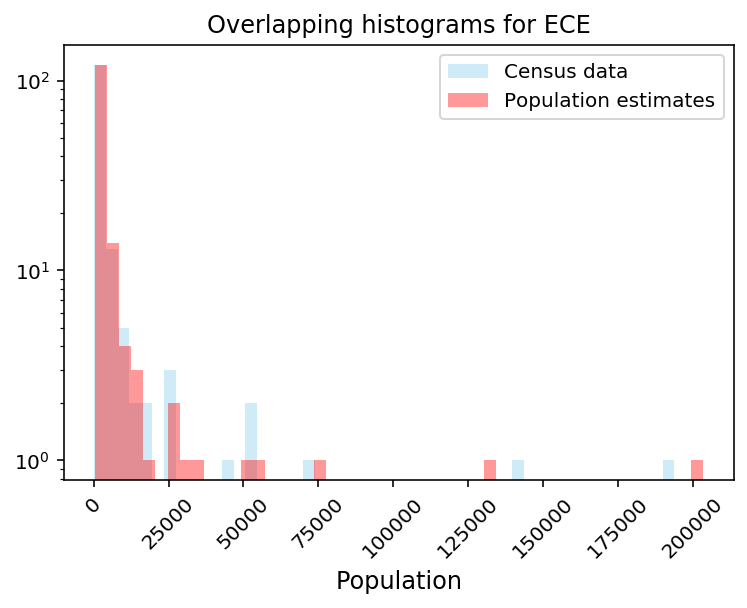

Pre-primary


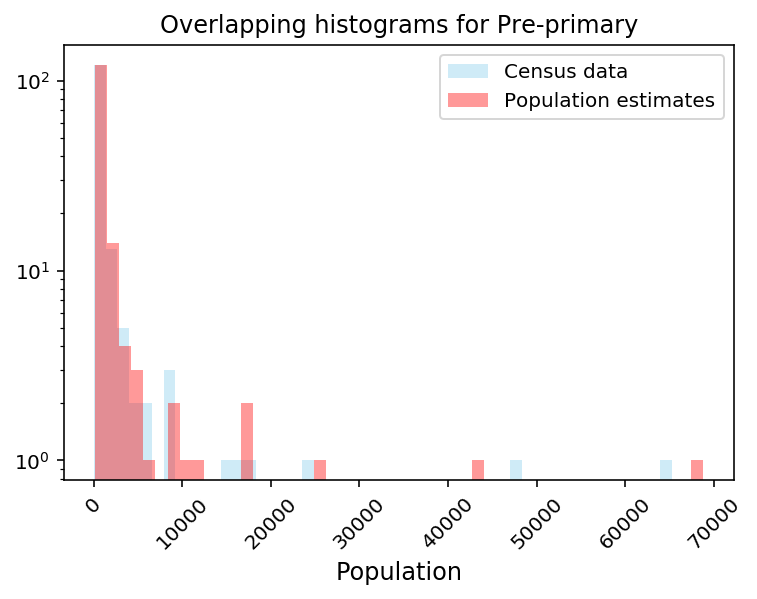

Primary


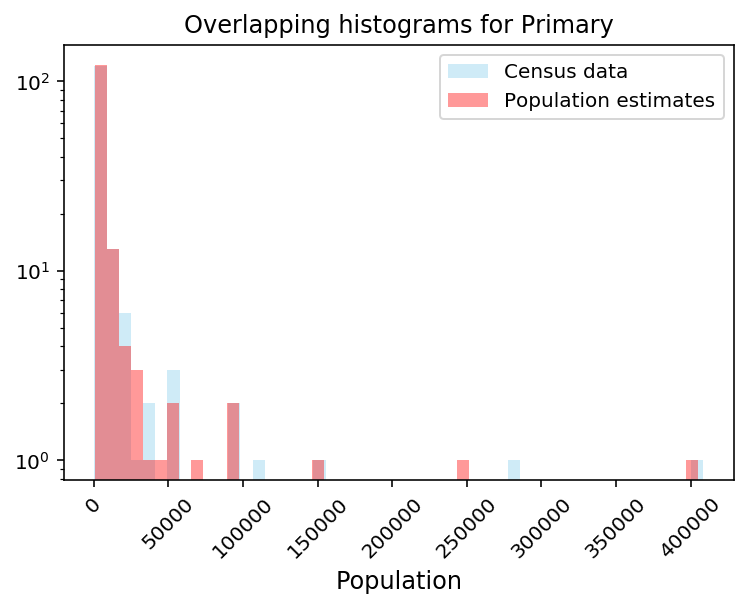

Lower secondary


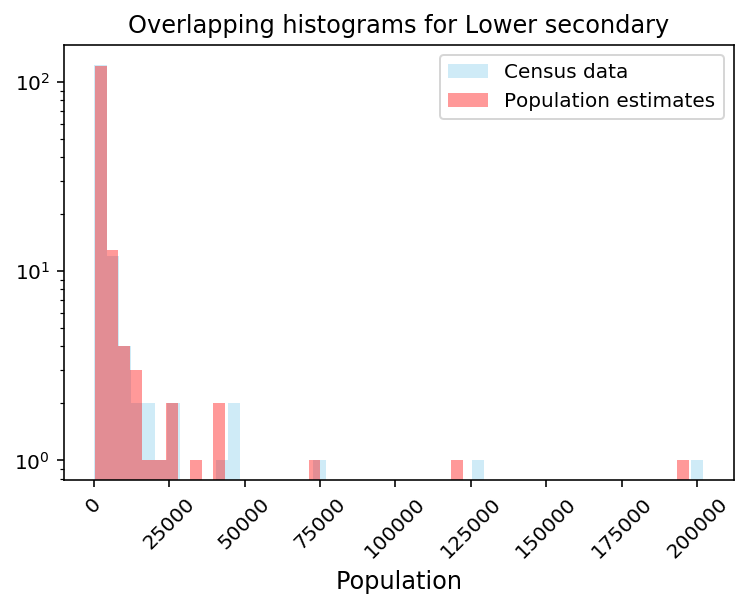

Upper secondary


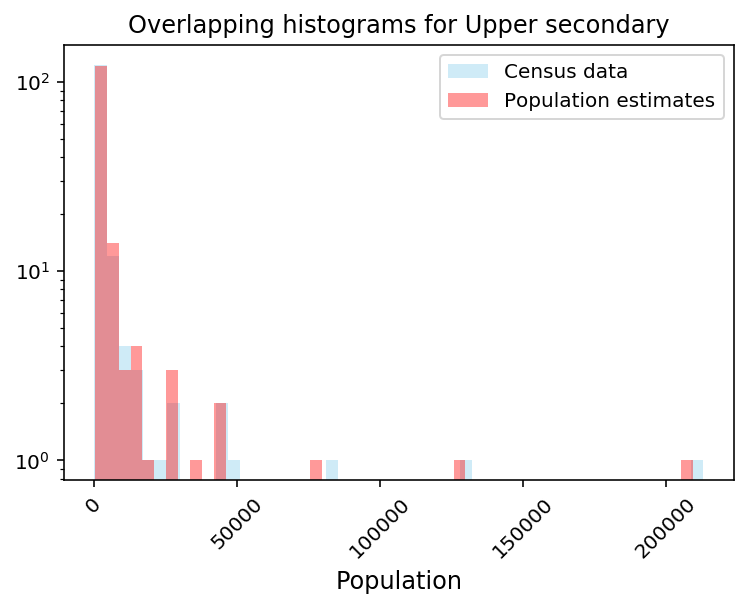

In [17]:
bars = ['ECE', 'Pre-primary', 'Primary', 'Lower secondary', 'Upper secondary']
for x in range(len(Levels)):
    print(bars[x])
    sns.distplot( MergedData["CD_"+Levels[x]] , color="skyblue", label="Census data", hist=True, kde=False, rug=False)
    sns.distplot( MergedData["PE_"+Levels[x]] , color="red", label="Population estimates", hist=True, kde=False, rug=False)
    plt.xlabel('Population', color = 'black', fontsize='12')
    plt.title("Overlapping histograms for " + bars[x])
    plt.legend()
    plt.xticks(color='black', rotation=45)
    plt.yscale('log')
    plt.show()


We then plot to see if the difference between the estimates and the actual data is related to the area of the polygon. While we see that there seems to be some relation, it is also clear that this behavior is also related to densely populated areas. This will be tested further down.

ECE


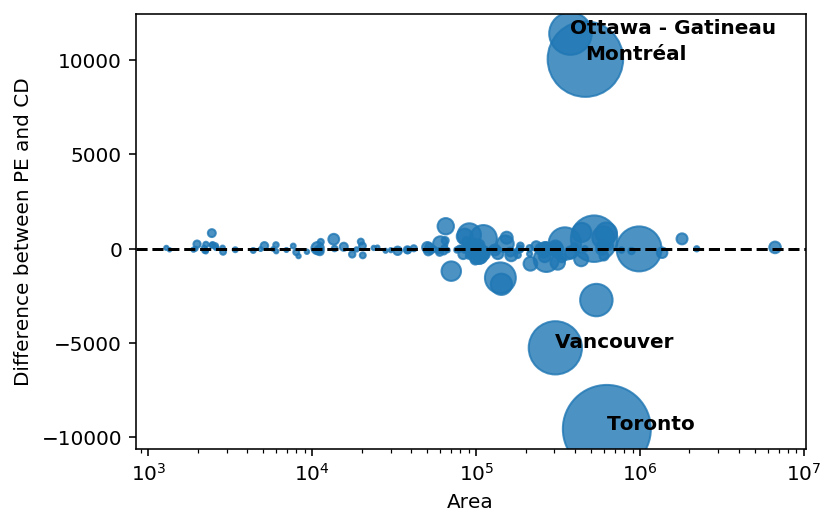

Pre-primary


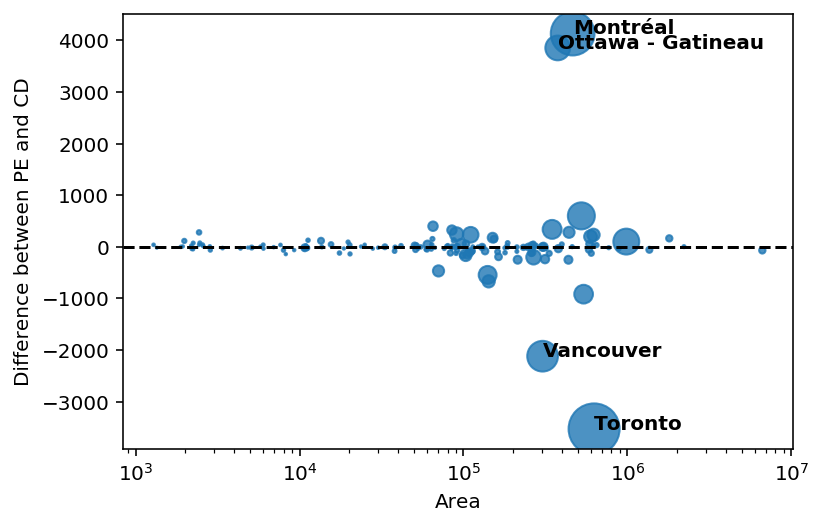

Primary


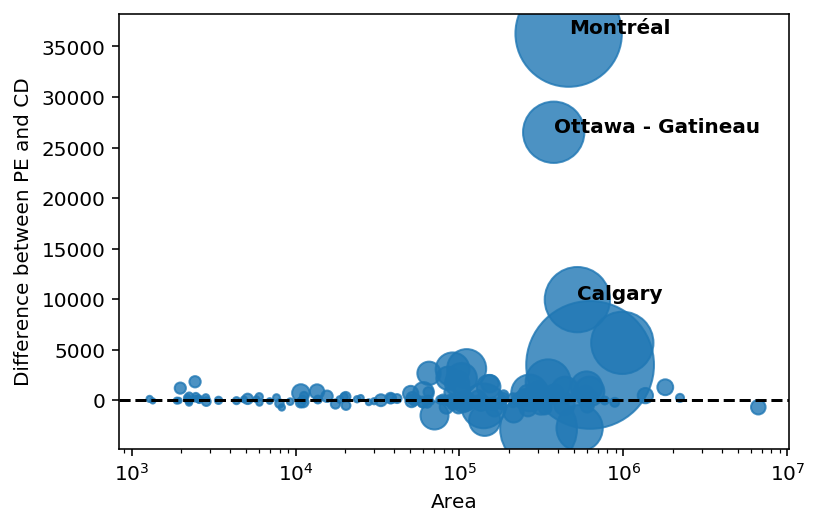

Lower secondary


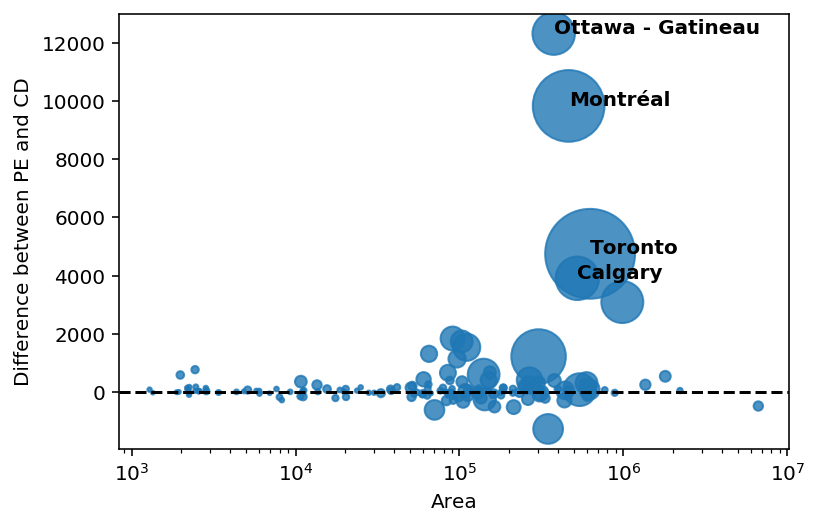

Upper secondary


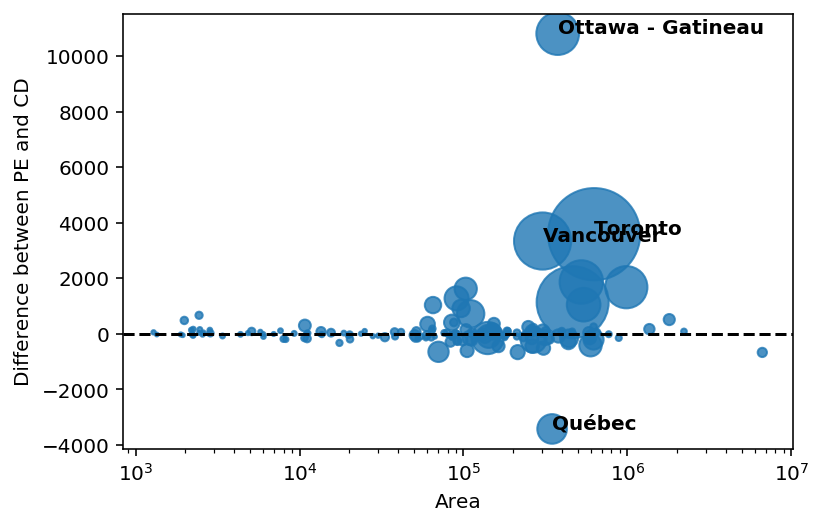

In [18]:
for x in range(len(Levels)):
    MergedData['Label_'+Levels[x]] = np.where(MergedData['Dif_'+Levels[x]]>=MergedData['Dif_'+Levels[x]].mean()+2*MergedData['Dif_'+Levels[x]].std(), MergedData['Name'],
                                              np.where(MergedData['Dif_'+Levels[x]]<=-MergedData['Dif_'+Levels[x]].mean()-2*MergedData['Dif_'+Levels[x]].std(), MergedData['Name'], ''))
    print(bars[x])
    p1 = sns.regplot(x=MergedData['Area'], y=MergedData['Dif_'+Levels[x]], scatter_kws={'s':MergedData['CD_'+Levels[x]]/100}, fit_reg=False)
    
    for line in range(0,MergedData.shape[0]):
        p1.text(MergedData['Area'][line]+0.2, MergedData['Dif_'+Levels[x]][line], MergedData['Label_'+Levels[x]][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.ylabel('Difference between PE and CD')
    plt.xscale('log')
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.show()

If this methodology is to predict accurately the same information obtained from the Census, a regression fit between both series should yield a regression coefficient close to one. 

In [19]:
Results = {}
for x in range(len(Levels)):
    formula = "PE_"+Levels[x]+"_std ~ CD_"+Levels[x]+"_std"
    result = sm.ols(formula=formula, data=MergedData).fit()
    heteroscedasticity_test = diag.het_breuschpagan(result.resid, result.model.exog)
    if heteroscedasticity_test[-1] <= 0.05:
        # The hypothesis that the error variance does not depend on x is rejected. There exists heteroscedasticity 
        result = sm.ols(formula=formula, data=MergedData).fit(cov_type='HC0')
        print("Robust regression results for "+bars[x]+"\n")
        print(result.summary())
        print("\n")
        T_test = result.t_test('CD_'+Levels[x]+'_std = 1')
        print("\nP-Value:{0} T-Statistic:{1}".format(T_test.pvalue,T_test.tvalue))
        if T_test.pvalue>0.05:
            print("No statistical difference between census data and population estimates for "+bars[x]+"\n")
        else:
            print("Evidence of statistical difference between census data and population estimates for "+Levels[x]+"\n")
        Results[Levels[x]] = {'Coefficient': T_test.effect[0], 'Std': T_test.sd[0][0], 't_test': T_test.tvalue[0][0], 'p_value': T_test.pvalue, 'R_square':result.rsquared, 'Robust':'Yes'}
    else:
        # The hypothesis that the error variance does not depend on x is kept. There is no heteroscedasticity 
        result = sm.ols(formula=formula, data=MergedData).fit()
        print("Regression results for "+bars[x]+"\n")
        print(result.summary())
        print("\n")
        T_test = result.t_test('CD_'+Levels[x]+'_std = 1')
        print("\nP-Value:{0} T-Statistic:{1}".format(T_test.pvalue,T_test.tvalue[0][0]))
        if T_test.pvalue>0.05:
            print("No statistical difference between census data and population estimates for "+bars[x]+"\n")
        else:
            print("Evidence of statistical difference between census data and population estimates for "+Levels[x]+"\n")
        Results[Levels[x]] = {'Coefficient': T_test.effect[0], 'Std': T_test.sd[0][0], 't_test': T_test.tvalue[0][0], 'p_value': T_test.pvalue, 'R_square':result.rsquared, 'Robust':'No'}


Regression results for ECE

                            OLS Regression Results                            
Dep. Variable:             PE_ECE_std   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.769e+04
Date:                Wed, 21 Oct 2020   Prob (F-statistic):          4.74e-172
Time:                        14:08:09   Log-Likelihood:                 181.81
No. Observations:                 152   AIC:                            -359.6
Df Residuals:                     150   BIC:                            -353.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.939e-17   

c:\users\g.vargas\documents\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
c:\users\g.vargas\documents\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\g.vargas\documents\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\g.vargas\documents\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [20]:
Results = pd.DataFrame.from_dict(Results)
Results = Results.transpose()
Results['ConfidenceInterval'] = 1.98*Results['Std']
Results['Color'] = np.where(Results['Robust']=='Yes','lightblue','darkolivegreen')
Results = Results.transpose()
Results

,ECE,PrePrimary,Primary,LowSec,UpSec
Coefficient,0.997302,0.996641,0.997198,0.998627,0.999059
Std,0.00599373,0.0380128,0.0334262,0.0165848,0.0075601
t_test,-0.450137,-0.0883697,-0.0838216,-0.0827735,-0.124501
p_value,0.65326158608797,0.9295828604520073,0.9331982344111183,0.93403161083274,0.9009187714337069
R_square,0.994611,0.993293,0.994404,0.997256,0.998118
Robust,No,Yes,Yes,Yes,Yes
ConfidenceInterval,0.0118676,0.0752653,0.0661839,0.0328379,0.014969
Color,darkolivegreen,lightblue,lightblue,lightblue,lightblue


We find that these coefficients are statistically equal to 1, with 99% of confidence. 

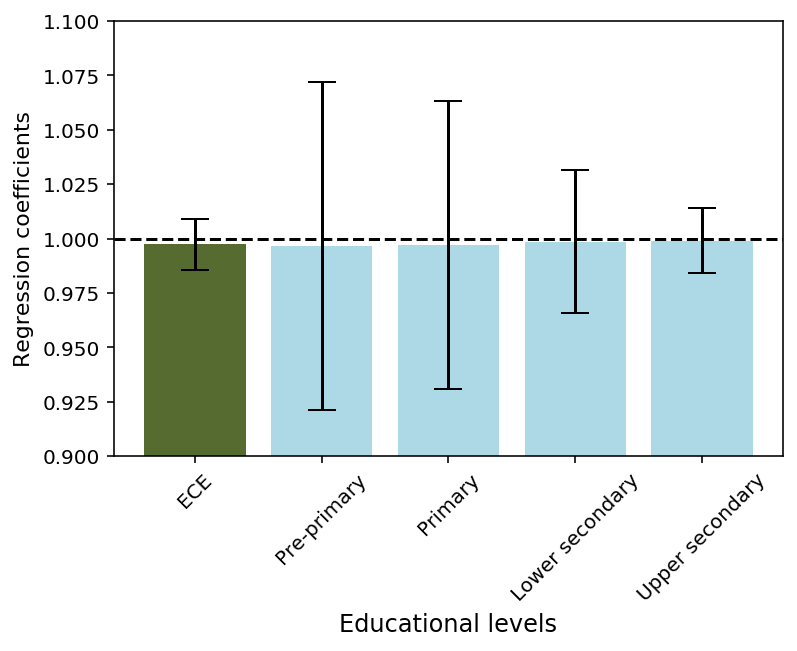

In [21]:
height = list(Results.loc['Coefficient'])
colors = list(Results.loc['Color'])
y_pos = np.arange(len(bars))
yer1 = list(Results.loc['ConfidenceInterval'])
plt.bar(y_pos, height, yerr=yer1, capsize=7, color=colors)
plt.xlabel('Educational levels', color = 'black', fontsize='12')
plt.ylabel('Regression coefficients', color='black', fontsize='11')
plt.xticks(y_pos, bars, color='black', rotation=45)
plt.yticks(color='black')
plt.axhline(y=1, color='black', linestyle='dashed')
plt.ylim(0.9,1.1)
plt.show()

Furthermore, as is to be expected of such a methodology, the regression fit, the R squared, is very close to 1, which indicated potential multicollineality (a positive trait in this case).

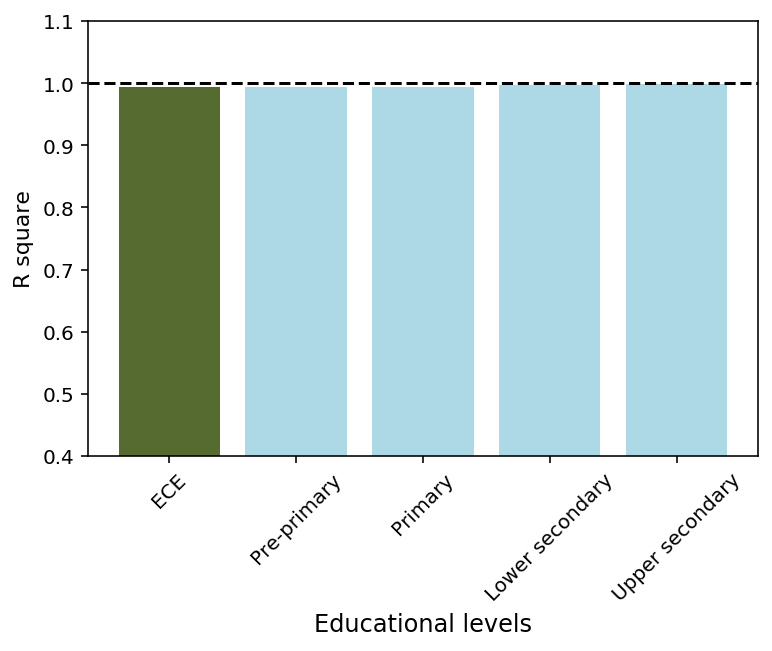

In [22]:
height = list(Results.loc['R_square'])
colors = list(Results.loc['Color'])
y_pos = np.arange(len(bars))
plt.bar(y_pos, height, color=colors)
plt.xlabel('Educational levels', color = 'black', fontsize='12')
plt.ylabel('R square', color='black', fontsize='11')
plt.xticks(y_pos, bars, color='black', rotation=45)
plt.yticks(color='black')
plt.axhline(y=1, color='black', linestyle='dashed')
plt.ylim(0.4,1.1)
plt.show()

Testing for normality of the difference between both series shows there is not normality, although this is mainly because of considerable outliers (those highly populated areas seen before). 

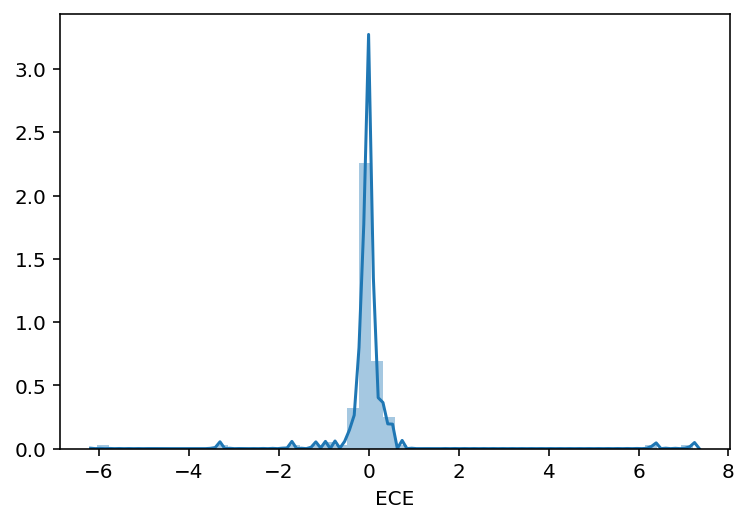

The difference between the Population estimates and the
Census data is not normally distributed for ECE


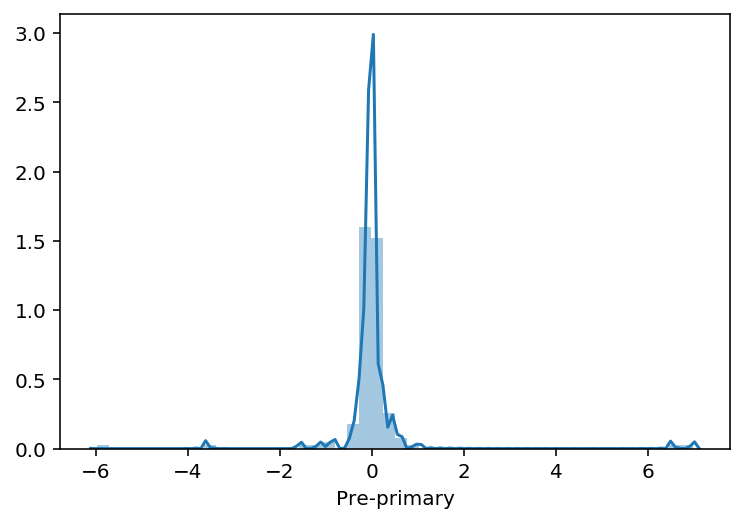

The difference between the Population estimates and the
Census data is not normally distributed for Pre-primary


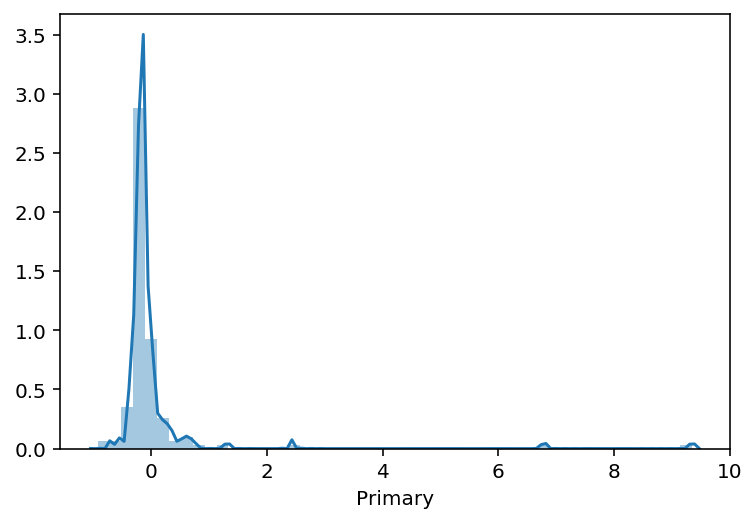

The difference between the Population estimates and the
Census data is not normally distributed for Primary


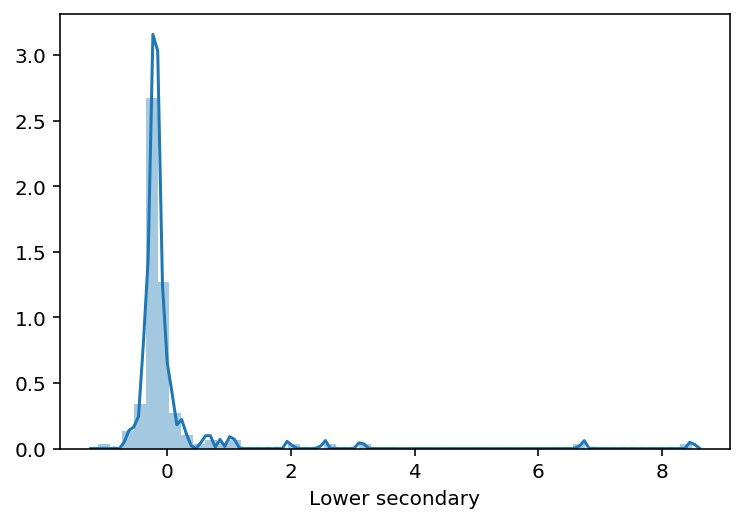

The difference between the Population estimates and the
Census data is not normally distributed for Lower secondary


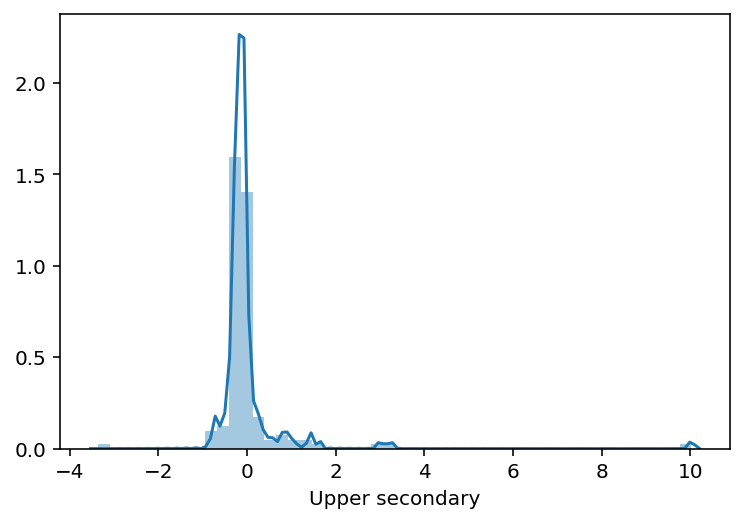

The difference between the Population estimates and the
Census data is not normally distributed for Upper secondary


In [23]:
for x in range(len(Levels)):
    sns.distplot( MergedData["Dif_"+Levels[x]+"_std"])
    plt.xlabel(bars[x])
    plt.show()
    jbt = jarque_bera(MergedData["Dif_"+Levels[x]+"_std"])
    if jbt[1]>0.05:
        print("The difference between the Population estimates and the")
        print("Census data is normally distributed for "+bars[x])
    else:
        print("The difference between the Population estimates and the")
        print("Census data is not normally distributed for "+bars[x])

Most of these outliers are eliminated once this is taken into account (by normalizing the difference between both series by the actual number of inhabitants).

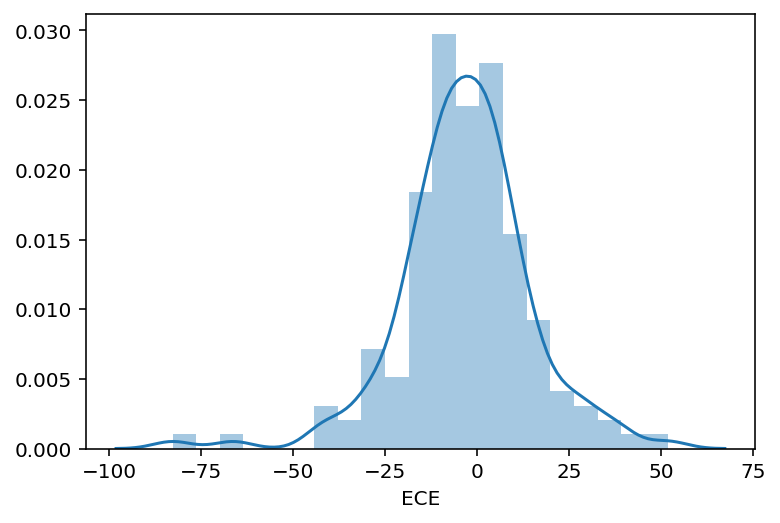

The difference between the Population estimates and the
Census data is not normally distributed for ECE


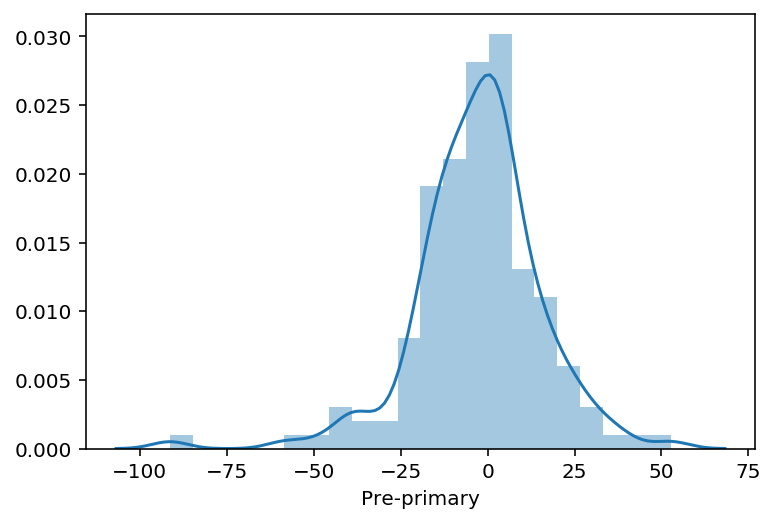

The difference between the Population estimates and the
Census data is not normally distributed for Pre-primary


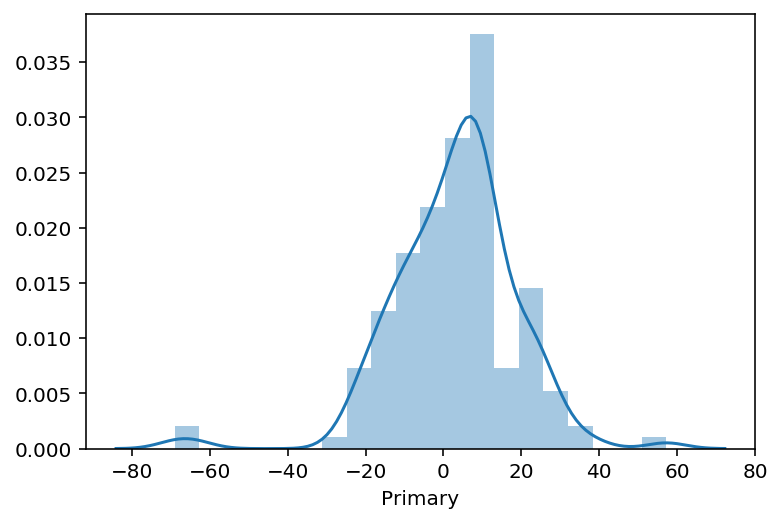

The difference between the Population estimates and the
Census data is not normally distributed for Primary


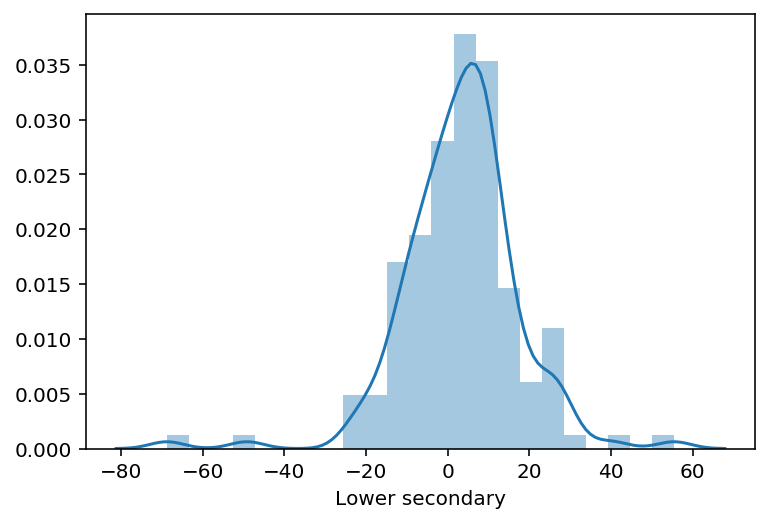

The difference between the Population estimates and the
Census data is not normally distributed for Lower secondary


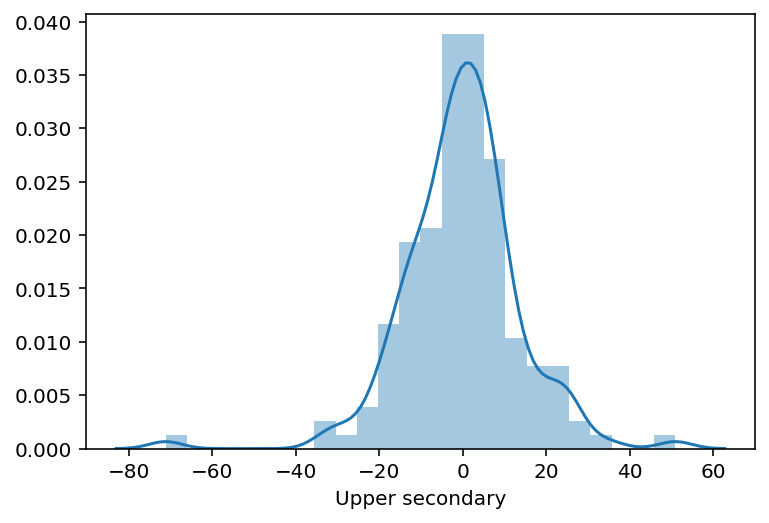

The difference between the Population estimates and the
Census data is not normally distributed for Upper secondary


In [24]:
for x in range(len(Levels)):
    MergedData['Perc_Dif_'+Levels[x]] = MergedData['Dif_'+Levels[x]]/MergedData['CD_'+Levels[x]]*100
    sns.distplot( MergedData['Perc_Dif_'+Levels[x]])
    plt.xlabel(bars[x])
    plt.show()
    jbt = jarque_bera(MergedData['Perc_Dif_'+Levels[x]])
    if jbt[1]>0.05:
        print("The difference between the Population estimates and the")
        print("Census data is normally distributed for "+bars[x])
    else:
        print("The difference between the Population estimates and the")
        print("Census data is not normally distributed for "+bars[x])

Finally, we see there is a high level of heteroscedasticity (as a function of the population size), with variance increasing with the number of people per administrative unit in the census...

ECE


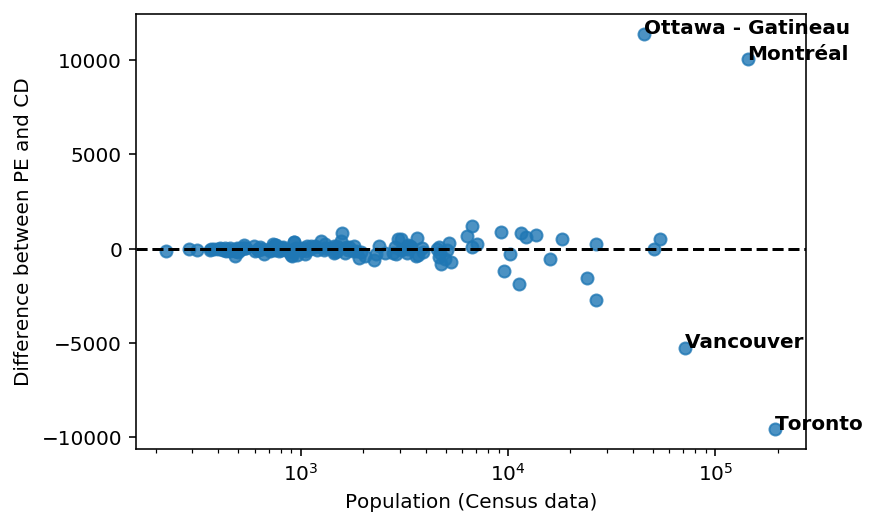

Pre-primary


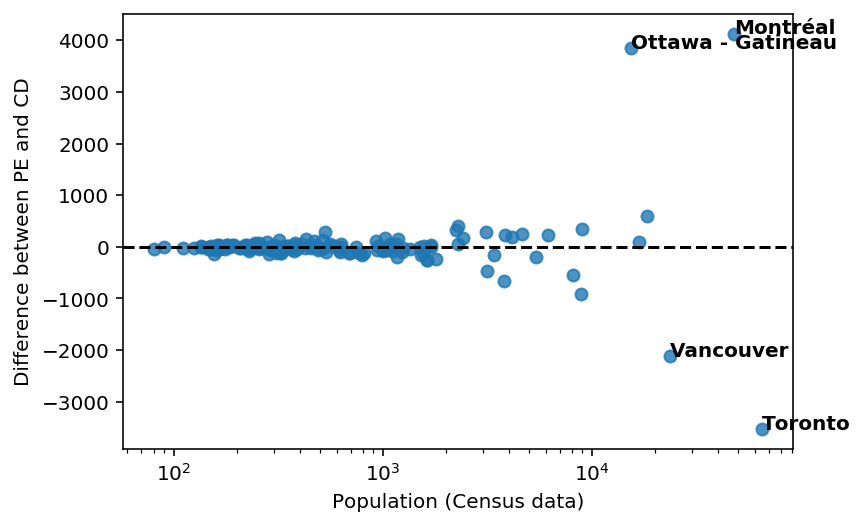

Primary


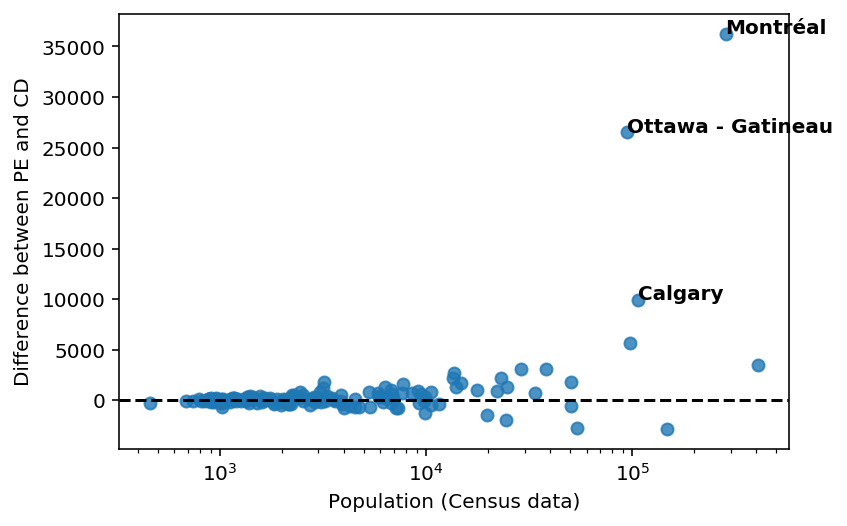

Lower secondary


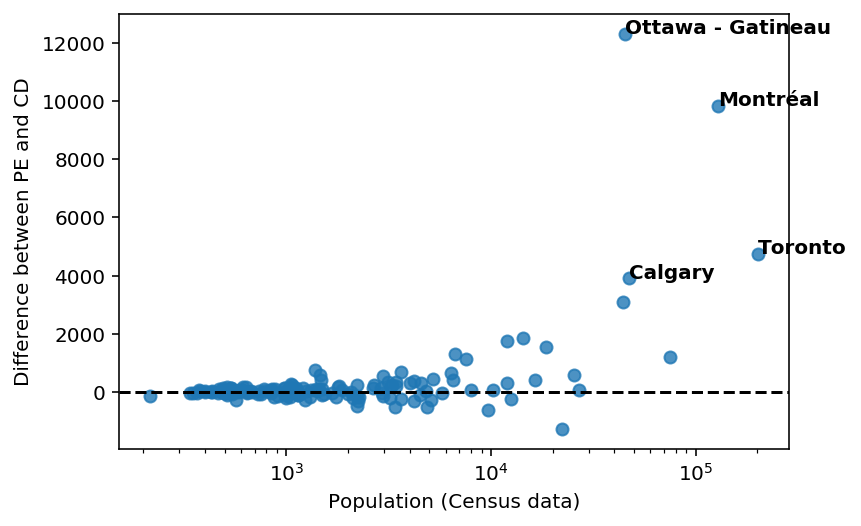

Upper secondary


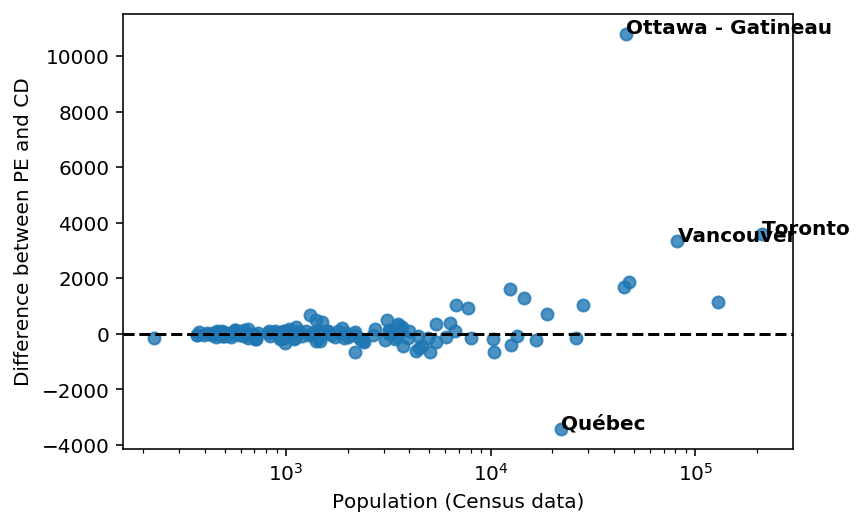

In [25]:
for x in range(len(Levels)):
    print(bars[x])
    p1 = sns.regplot(x=MergedData['CD_'+Levels[x]], y=MergedData['Dif_'+Levels[x]], fit_reg=False)
    
    for line in range(0,MergedData.shape[0]):
        p1.text(MergedData['CD_'+Levels[x]][line]+0.2, MergedData['Dif_'+Levels[x]][line], MergedData['Label_'+Levels[x]][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.ylabel('Difference between PE and CD')
    plt.xlabel('Population (Census data)')
    plt.xscale('log')
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.show()

... but such a behavior disappears once we use the percentage of the difference as a function of the total population, rather than the population as a whole. 

ECE


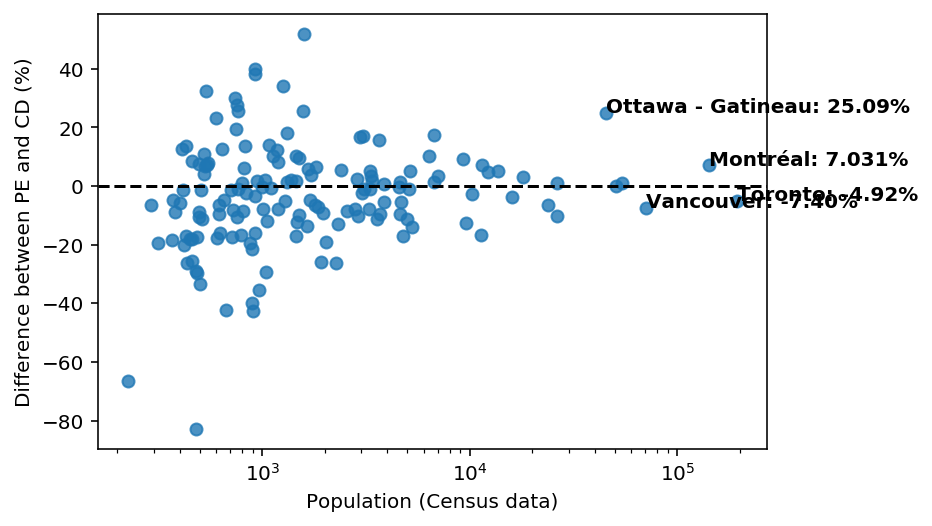

Pre-primary


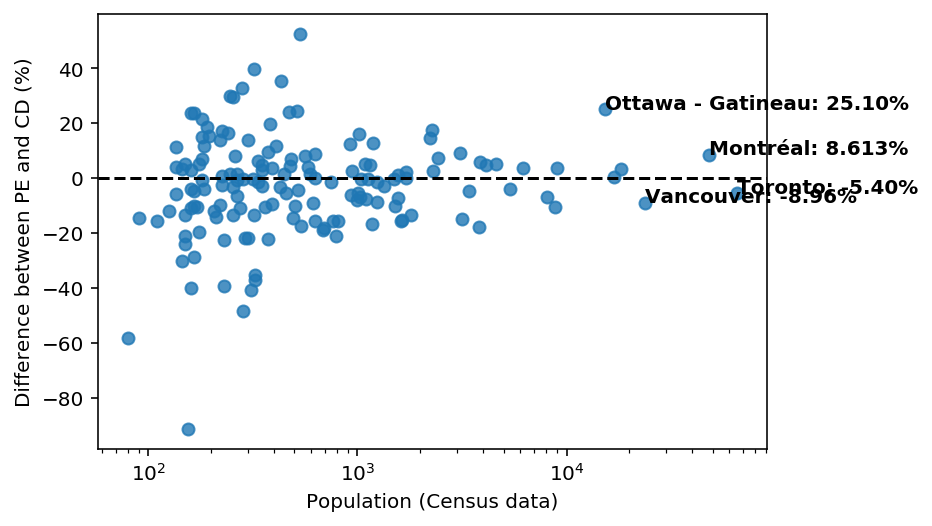

Primary


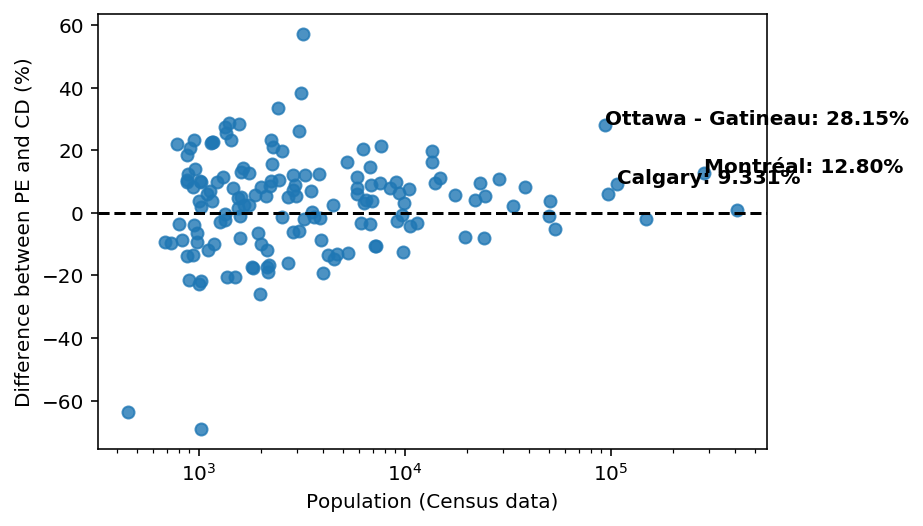

Lower secondary


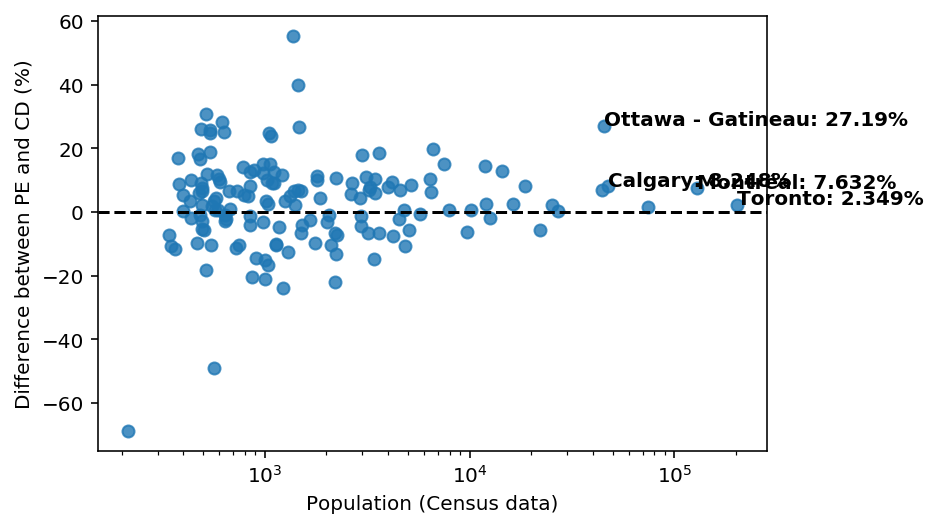

Upper secondary


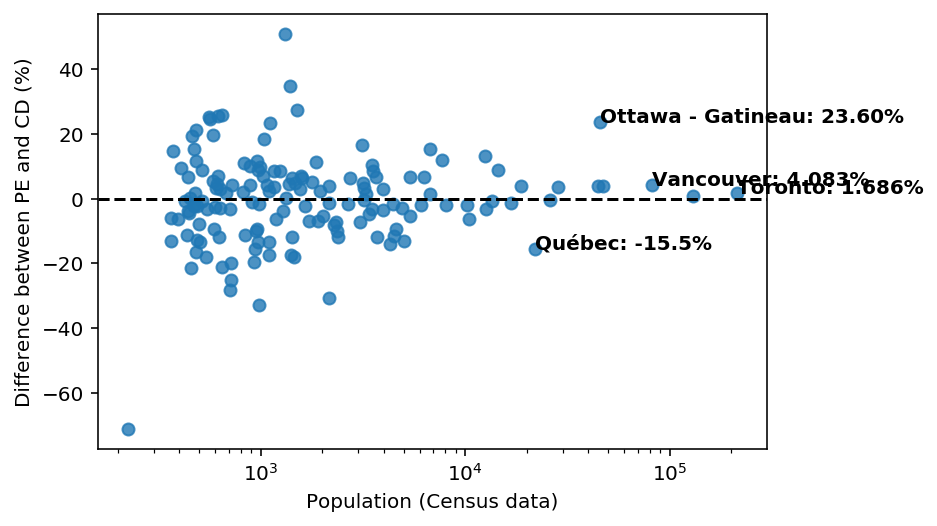

In [26]:
for x in range(len(Levels)):
    print(bars[x])
    p1 = sns.regplot(x=MergedData['CD_'+Levels[x]], y=MergedData['Perc_Dif_'+Levels[x]], fit_reg=False)
    for line in range(0,MergedData.shape[0]):
        if MergedData['Label_'+Levels[x]][line]!='':
            p1.text(MergedData['CD_'+Levels[x]][line]+0.2, MergedData['Perc_Dif_'+Levels[x]][line], MergedData['Label_'+Levels[x]][line]+': '+str(MergedData['Perc_Dif_'+Levels[x]][line])[:5]+'%', horizontalalignment='left', size='medium', color='black', weight='semibold')
        else:
            p1.text(MergedData['CD_'+Levels[x]][line]+0.2, MergedData['Perc_Dif_'+Levels[x]][line], MergedData['Label_'+Levels[x]][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.ylabel('Difference between PE and CD (%)')
    plt.xlabel('Population (Census data)')
    plt.xscale('log')
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.show()

The methodology holds even when looking at the odds ratio between Females and Males.

ECE


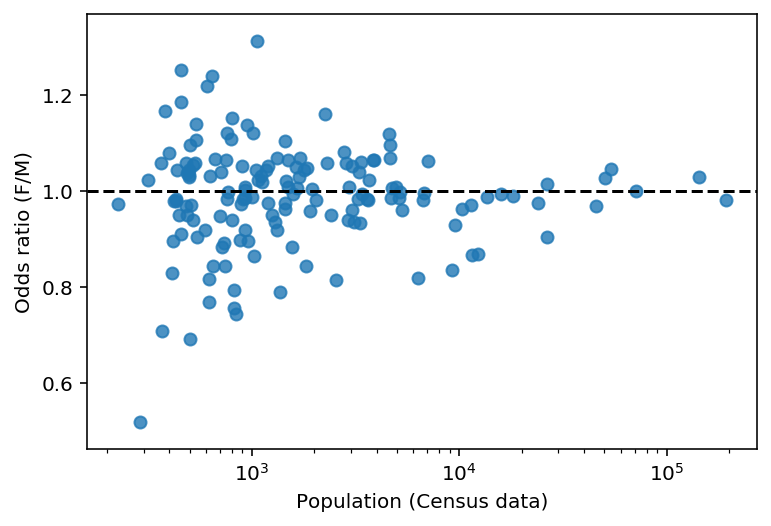

Pre-primary


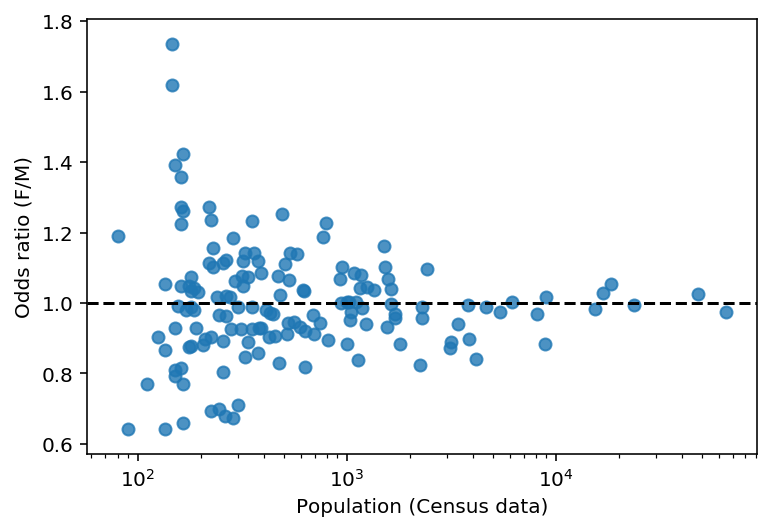

Primary


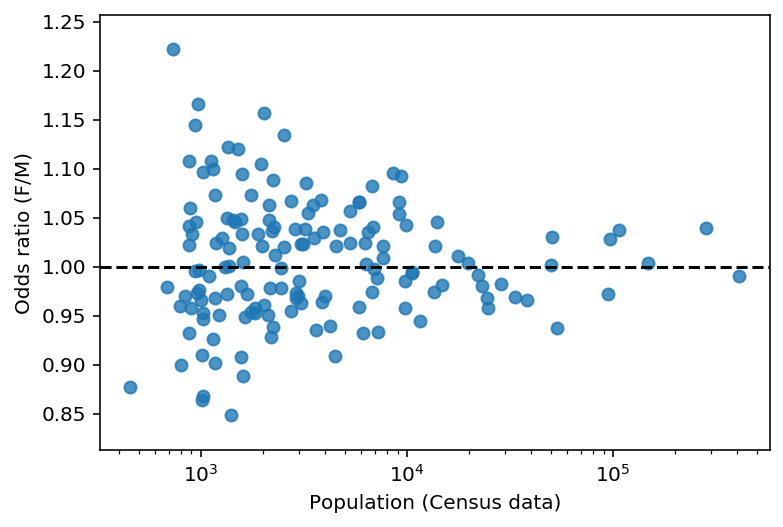

Lower secondary


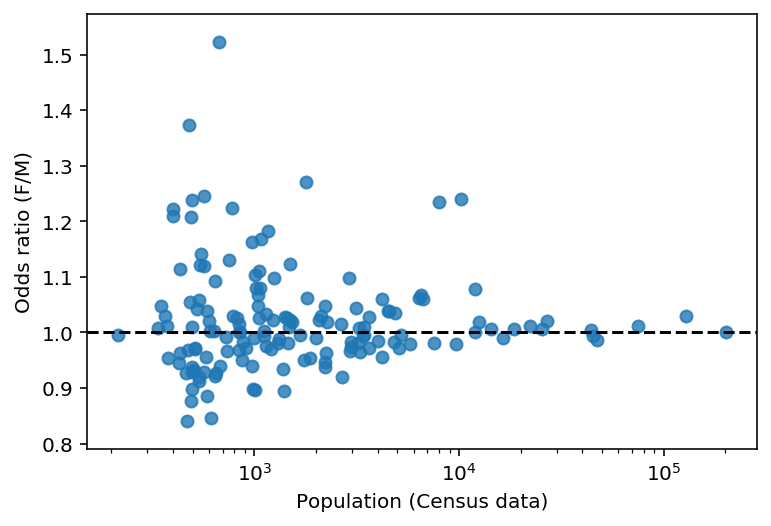

Upper secondary


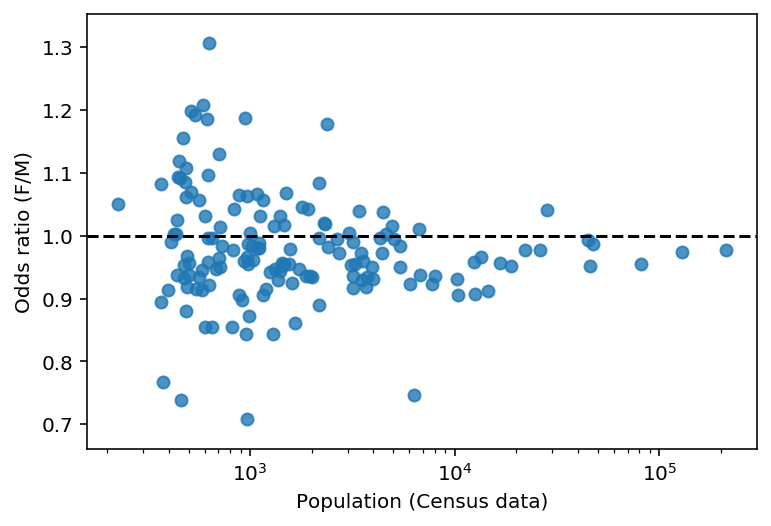

In [27]:
for x in range(len(Levels)):
    print(bars[x])
    MergedData['OddsRatio_'+Levels[x]] = (MergedData['PE_'+Levels[x]+'_Female']/MergedData['CD_'+Levels[x]+'_Female'])/(MergedData['PE_'+Levels[x]+'_Male']/MergedData['CD_'+Levels[x]+'_Male'])
    p1 = sns.regplot(x=MergedData['CD_'+Levels[x]], y=MergedData['OddsRatio_'+Levels[x]], fit_reg=False)
    plt.ylabel('Odds ratio (F/M)')
    plt.xlabel('Population (Census data)')
    plt.xscale('log')
    plt.axhline(y=1, color='black', linestyle='dashed')
    plt.show()